


# https://drive.google.com/open?id=1YIZLHl0YRsd_1GkYf9KPJB2wEcxRzJns 
# LINK TO GOOGLE COLAB TO RUN

In [0]:
import numpy as np
import scipy
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plot
plot.style.use('fivethirtyeight')
%matplotlib inline
!pip install -U folium
!pip install geopandas
import geopandas
import folium
import json
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn import preprocessing
from sklearn.linear_model import Lars

from sklearn import metrics

from collections import Counter
from scipy import stats
from shapely.geometry import Point
from branca.colormap import linear
import branca.colormap
from folium.plugins import TimeSliderChoropleth

import seaborn as sns

from folium import plugins
import folium.plugins # The Folium Javascript Map Library
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from folium import CircleMarker

Requirement already up-to-date: folium in /usr/local/lib/python3.6/dist-packages (0.8.3)
     |████████████████████████████████| 901kB 4.7MB/s 
     |████████████████████████████████| 17.9MB 32.8MB/s 
     |████████████████████████████████| 10.8MB 24.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


     |████████████████████████████████| 993kB 5.0MB/s 


In [0]:
crime_data_link = 'https://drive.google.com/open?id=1zo0uQpXS8OaO1p1wGPFiYinkrPjvxkSG'

In [0]:
fluff_crime, id_crime_data = crime_data_link.split('=')
print (id_crime_data) # Verify that you have everything after '='

1zo0uQpXS8OaO1p1wGPFiYinkrPjvxkSG


In [0]:
downloaded_crime_data = drive.CreateFile({'id':id_crime_data}) 
downloaded_crime_data.GetContentFile('Crime_Data_from_2010_to_Present.csv')  
crime_data = pd.read_csv('Crime_Data_from_2010_to_Present.csv')
# Dataset is now stored in a Pandas Dataframe
crime_data.head()


DR Number Date Reported Date Occurred  Time Occurred  Area ID    Area Name  \
0  151521112    11/04/2015    11/03/2015           2230      NaN  N Hollywood   
1  151521113    11/04/2015    10/30/2015            200      NaN  N Hollywood   
2  151521117    11/04/2015    11/04/2015           1400      NaN  N Hollywood   
3  151521121    11/04/2015    04/28/2015           2125      NaN  N Hollywood   
4  151521123    11/05/2015    10/27/2015            600      NaN  N Hollywood   

   Reporting District  Crime Code                  Crime Code Description  \
0                1555         330                   BURGLARY FROM VEHICLE   
1                1548         330                   BURGLARY FROM VEHICLE   
2                1506         930  CRIMINAL THREATS - NO WEAPON DISPLAYED   
3                1567         121                          RAPE, FORCIBLE   
4                1515         354                       THEFT OF IDENTITY   

                                  MO Codes  ...  \
0                                     0344  ...   
1                           0344 1609 1307  ...   
2                                     0421  ...   
3  2000 0429 1241 0416 0400 0527 1813 2002  ...   
4                                0100 1822  ...   

                               Weapon Description Status Code  \
0                                             NaN          IC   
1                                             NaN          IC   
2                                   VERBAL THREAT          JA   
3  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)          AO   
4                                             NaN          IC   

  Status Description  Crime Code 1 Crime Code 2  Crime Code 3 Crime Code 4  \
0        Invest Cont         330.0          NaN           NaN          NaN   
1        Invest Cont         330.0          NaN           NaN          NaN   
2         Juv Arrest         930.0          NaN           NaN          NaN   
3        Adult Other         121.0          NaN           NaN          NaN   
4        Invest Cont         354.0          NaN           NaN          NaN   

                                    Address Cross Street             Location   
0  11100    CAMARILLO                    ST          NaN  (34.1577, -118.3727)  
1  11100    CHANDLER                     BL          NaN  (34.1681, -118.3724)  
2   7300    BAKMAN                       AV          NaN   (34.203, -118.3779)  
3  10700    LANDALE                      ST          NaN  (34.1513, -118.3642)  
4  11700    LEMAY                        ST          NaN  (34.1912, -118.3891)  

[5 rows x 26 columns]

<b> First, Let's take a look at the crime dataset that we will be working with. This data was retrieved from the City of Los Angeles's Open Data portal, located at https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/y8tr-7khq. It contains records of crime incidents from 2010 to present, and is transcribed from original crime reports that are typed on paper, and the city notes that  there may be some inaccuracies within the data as a result.


---



  

# The Crime Data

In [0]:
crime_by_area = crime_data["Area Name"].value_counts().to_frame().reset_index()
crime_by_area.rename(columns = {'index': 'Area Name', 'Area Name': 'Count'}, inplace = True)

crime_by_area['Proportion'] = crime_by_area['Count']/crime_by_area['Count'].sum()
crime_by_area['Percentage'] = crime_by_area['Proportion']*100
crime_by_area.sort_values('Count', ascending = False).head()

Area Name   Count  Proportion  Percentage
0  77th Street  133040    0.069026    6.902567
1    Southwest  123969    0.064319    6.431932
2  N Hollywood  104413    0.054173    5.417301
3      Pacific  102088    0.052967    5.296672
4    Southeast  101358    0.052588    5.258797

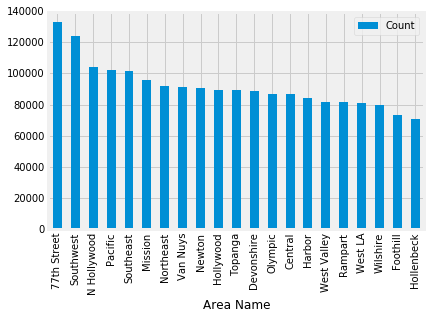

In [0]:
#barplot of crime counts
crime_area_bp = crime_by_area.plot.bar("Area Name", "Count")

<b> So from a bar plot and some quick calculations, its clear that 77th Street division and Southwest division are the areas that see the most crime. The two each see about 20,000 to 30,000 more incidents than the third placed area, North Hollywood.  From North Hollywood onwards, the crime count disparity between consecutively placed areas is nowhere as large. 
  
  Hollenbeck division is the area that sees the lowest proportion of crime, accounting for 3.676% or just 70,852 crimes.

<b> Now, let's get some basic stats on crime categories. In our dataframe, this information is listed as 'Crime Code Description'.

In [0]:
crime_by_cat = crime_data["Crime Code Description"].value_counts().to_frame().reset_index()
crime_by_cat.rename(columns = {'index': 'Crime Code Description', 'Crime Code Description': 'Count'}, inplace = True)

crime_by_cat['Proportion'] = crime_by_cat['Count']/crime_by_cat['Count'].sum()
crime_by_cat['Percentage'] = crime_by_cat['Proportion']*100
crime_by_cat.sort_values('Count', ascending = False).head()

Crime Code Description   Count  Proportion  Percentage
0            BATTERY - SIMPLE ASSAULT  174585    0.090581    9.058062
1               BURGLARY FROM VEHICLE  148380    0.076985    7.698458
2                    VEHICLE - STOLEN  147233    0.076389    7.638948
3                            BURGLARY  137207    0.071188    7.118765
4  THEFT PLAIN - PETTY ($950 & UNDER)  136876    0.071016    7.101591

<b> We see that there are 140 crime codes in this data set, and that the most common category of crime is BATTERY - SIMPLE ASSAULT accounting for	174585 incidents and 	9.058062% of the incidents in the data set. BURGLARY FROM VEHICLE	and	VEHICLE - STOLEN	are not too far behind in second and third place. The least common incidents, with just one occurence is "FIREARMS TEMPORARY RESTRAINING ORDER".

The top three crime categories account for about 25% of all incidents. Something interesting to note is the nature of these categories is quite different from that of San Francisco's database, where Larceny and Petty Theft accounted for the plurality of incidents and auto theft and burgulary from vehicles accounted for quite few incidents. Perhaps this is due to differences in density, public transportation, area of the cities. This bit of information may be useful later, as it might inform us on the feasibility of applying a model designed to predcit crime in Los Angeles to other cities like San Francisco.

In [0]:
crime_cat_area = crime_data[['Crime Code Description', 'Area Name']]
# pivot for counts by area and categories
crime_cat_area_pvt = crime_cat_area.pivot_table(columns = "Area Name" ,index = "Crime Code Description", aggfunc = np.count_nonzero)
crime_cat_area_pvt

#maximum category by district
max_cat_by_district = crime_cat_area_pvt.idxmax(axis=0).to_frame().rename(columns={0: "Most common incident"})
max_cat_by_district.head()

Most common incident
Area Name                            
77th Street  BATTERY - SIMPLE ASSAULT
Central      BATTERY - SIMPLE ASSAULT
Devonshire                   BURGLARY
Foothill             VEHICLE - STOLEN
Harbor               VEHICLE - STOLEN

<b> BATTERY - SIMPLE ASSAULT accounted for the most common incident type in 7 districts. VEHICLE - STOLEN accounted for the most common incident in 6 districts. BURGULARY accounted for the most common incident type in 5 districts. BURGLARY FROM VEHICLE accounted for the most common incident type in 2 districts. THEFT PLAIN - PETTY ($950 & UNDER) accounted for the most common incident type in 1 district.


BATTERY - SIMPLE ASSAULT was the most common incident overall, and so it's not very surprising that it is most common in more districts than others. What's somewhat unexpected is that BURGULARY FROM VEHICLE accounts for the second most common incident type overall, but is only the most common incident type in 2 districts.


In [0]:
max_cat_by_district['max count'] = 'default value'

for i in list(crime_cat_area_pvt):
  max_cat_by_district.at[i, 'max count'] = crime_cat_area_pvt[i].max( skipna= True)
max_cat_by_district.head()

Most common incident max count
Area Name                                      
77th Street  BATTERY - SIMPLE ASSAULT     28194
Central      BATTERY - SIMPLE ASSAULT     26304
Devonshire                   BURGLARY     18116
Foothill             VEHICLE - STOLEN     14996
Harbor               VEHICLE - STOLEN     17872

<b> Roughly speaking, we can see that when BATTERY -SIMPLE ASSAULT tends to be the most common incident in district, the number of such incidents is greater than when other incident types are the most common incident. Interestingly, we see that counts of VEHICLE -STOLEN  when most common incident are higher than when BURGULARY is the most common event. Also note that 77th and Southwest, as the districts with the most incidents overall, also have the highest occurence of their most common incidents. 

<b> Because we are interested in finding geographical patterns in crime, let's create some plots of  the incidents on a map to see if we can get a better idea of what we're dealing with.

In [0]:
from shapely.geometry import Point

In [0]:
point_list = []
loc_fixed = []
for i in crime_data['Location ']:
  t = list(eval(i))
  c = Point(t[0], t[1])
  point_list.append(c)
  loc_fixed.append(t)

In [0]:
crime_data['geometry']=point_list
crime_data['location corrected'] = loc_fixed
crime_data.head()

DR Number Date Reported Date Occurred  Time Occurred  Area ID    Area Name  \
0  151521112    11/04/2015    11/03/2015           2230      NaN  N Hollywood   
1  151521113    11/04/2015    10/30/2015            200      NaN  N Hollywood   
2  151521117    11/04/2015    11/04/2015           1400      NaN  N Hollywood   
3  151521121    11/04/2015    04/28/2015           2125      NaN  N Hollywood   
4  151521123    11/05/2015    10/27/2015            600      NaN  N Hollywood   

   Reporting District  Crime Code                  Crime Code Description  \
0                1555         330                   BURGLARY FROM VEHICLE   
1                1548         330                   BURGLARY FROM VEHICLE   
2                1506         930  CRIMINAL THREATS - NO WEAPON DISPLAYED   
3                1567         121                          RAPE, FORCIBLE   
4                1515         354                       THEFT OF IDENTITY   

                                  MO Codes  ...  Status Description  \
0                                     0344  ...         Invest Cont   
1                           0344 1609 1307  ...         Invest Cont   
2                                     0421  ...          Juv Arrest   
3  2000 0429 1241 0416 0400 0527 1813 2002  ...         Adult Other   
4                                0100 1822  ...         Invest Cont   

  Crime Code 1 Crime Code 2  Crime Code 3 Crime Code 4  \
0        330.0          NaN           NaN          NaN   
1        330.0          NaN           NaN          NaN   
2        930.0          NaN           NaN          NaN   
3        121.0          NaN           NaN          NaN   
4        354.0          NaN           NaN          NaN   

                                    Address Cross Street  \
0  11100    CAMARILLO                    ST          NaN   
1  11100    CHANDLER                     BL          NaN   
2   7300    BAKMAN                       AV          NaN   
3  10700    LANDALE                      ST          NaN   
4  11700    LEMAY                        ST          NaN   

              Location                    geometry    location corrected  
0  (34.1577, -118.3727)  POINT (34.1577 -118.3727)  [34.1577, -118.3727]  
1  (34.1681, -118.3724)  POINT (34.1681 -118.3724)  [34.1681, -118.3724]  
2   (34.203, -118.3779)   POINT (34.203 -118.3779)   [34.203, -118.3779]  
3  (34.1513, -118.3642)  POINT (34.1513 -118.3642)  [34.1513, -118.3642]  
4  (34.1912, -118.3891)  POINT (34.1912 -118.3891)  [34.1912, -118.3891]  

[5 rows x 28 columns]

In [0]:
la_crime_point = folium.Map(location = [34.0522, -118.2437])

In [0]:
#sample for performance reasons
crime_data_sample = crime_data.sample(1000,replace = True)

In [0]:
for i in crime_data_sample['location corrected']:
   folium.CircleMarker(location = i,radius = 1).add_to(la_crime_point)

In [0]:
la_crime_point

<b> Right away we can see that crime is not even distributed over the areas that the Los Angeles Police Department serves. For one, It's important to note that LAPD service area is not one contiguous area, due to the fact that the City of Los Angeles is just one city in Los Angeles County, so areas that seem to be devoid of crime are actually the responsibility of other police departments: ie Santa Monica, Beverly Hills, Inglewood, Hawthorne, Downey, etc. 
  
  We can say that crime density appears to be greater in the central / Downtown LA area than in the Culver City, Harbor, and Northwest LA areas. 
  

<b> Perhaps a heatmap will also be useful in visualizing:

In [0]:
la_crime_heat = folium.Map(location = [34.0522, -118.2437])

In [0]:
# increased the sampple size because increasing the heatmap radius will not show desired information, with such a large area, more points are needed to construct a better heatmap

new_crime_data_sample = crime_data.sample(70000, replace = True)
la_heat_data = new_crime_data_sample['location corrected']

HeatMap(la_heat_data, radius = 10).add_to(la_crime_heat)

la_crime_heat

<b> Our heatmap confirms what we can deduce from the plot of points: it does appear that crime density is higher in downtown LA , South Central LA, than in other areas. In fact, northwest LA seems to be really relatively crime sparse save for some hotspots in Panorama City, Topanga. It seems that crime in northwest LA is actually quite evenly distributed.

<b> Since we're interested in possible relationships between the occurence of crime and the existence of certain establishments, perhaps it might be useful to try to measure this in some way. A metric that might be useful is the mean distance between closest crime incidents in our set, let's try to calculate this. This might be able to tell us something about crime density, and whether or not the occurence of crime perpetrates the occurence of more crime.

In [0]:
from shapely.geometry import MultiPoint
from shapely.ops import nearest_points

import collections
#Npoint = collections.namedtuple('Npoint', ['nearest', 'distance'])

import pyproj
from decimal import Decimal

from geopy.distance import great_circle
from geopy.distance import vincenty
from geopy.distance import distance

In [0]:
# a function to find the nearest points (that is not of the same incident, though the nearest point is allowed to be at the same physical location) to a specified point, and add their incident numbers to a column
def nearest(in_row, geom_col, df):
    """Find the nearest point and return its incident number and distance from the specified origin point"""
    minuspointdf = df[df['DR Number'] != in_row['DR Number']]
    un_union = minuspointdf.unary_union
    nearest_points_found = (nearest_points(in_row[geom_col], un_union))
    npf_list = list(nearest_points_found)
    nearest_point = minuspointdf[minuspointdf['geometry'].isin(npf_list)]
    return nearest_point['DR Number'].values

In [0]:
# create a geodataframe version of crime_data, with WGS84
from geopandas import GeoDataFrame
crime_data_gdf = GeoDataFrame(crime_data,crs = {'init' :'epsg:4326'}, geometry='geometry')

<b> Our first calculations will be performed on the overall random sample, crime_data_sample, from earlier. It's too computationally expensive to calculate on the entire data set, and this might contain so much information that it would serve to not yield meaningful results. So instead, we will calculate distances based on certain areas, times, types, etc

In [0]:
geod = pyproj.Geod(ellps='WGS84')

<b> Lets take a look at crimes that only occured in 2018:  2018 is a relatively recent year, so the comparisons we want to make with other data we are investigating are relevant, and isn't so recent that it would not be uncommon to see crimes that have already occurred still being reported.
 

In [0]:
crime_data_gdf.head()
dates_into_years = crime_data_gdf['Date Occurred'].str.split(pat="/", n=-1, expand=True)
crime_data_gdf['Year'] = dates_into_years[2]
crime_data_gdf['Year'] = crime_data_gdf['Year'].astype(int)

In [0]:
crime_data_2018_gdf = crime_data_gdf.loc[crime_data_gdf['Year'] ==2018]
print ("Number of incidents in 2018:" ,len(crime_data_2018_gdf))

Number of incidents in 2018: 225694


In [0]:
crime_data_2018_gdf_sample = crime_data_2018_gdf.sample(1000, replace = False)

In [0]:
nn18 = []
for index, row in crime_data_2018_gdf_sample.iterrows():
  nn18.append(nearest(row, 'geometry', crime_data_2018_gdf_sample))  


In [0]:
crime_data_2018_gdf_sample['closest'] = nn18

dd18 = []

for index, row in crime_data_2018_gdf_sample.iterrows():
  close_loc = crime_data_2018_gdf_sample.loc[crime_data_2018_gdf_sample['DR Number'] == (row['closest'][0])]["Location "]
  dd18.append(distance(row['Location '], close_loc).km)

In [0]:
crime_data_2018_gdf_sample['distance to closest'] = dd18
crime_data_2018_gdf_sample.head()

print("AVERAGE distance from crime point to nearest crime point, 2018 overall sample: in Kilometers", np.mean(crime_data_2018_gdf_sample['distance to closest']))
print("MAX distance from crime point to nearest crime point, 2018 overall sample: in Kilometers", np.max(crime_data_2018_gdf_sample['distance to closest']))
print("MIN distance from crime point to nearest crime point, 2018 overall sample: in Kilometers", np.min(crime_data_2018_gdf_sample['distance to closest']))
print("MEDIAN distance from crime point to nearest crime point, 2018 overall sample: in Kilometers", np.median(crime_data_2018_gdf_sample['distance to closest']))

AVERAGE distance from crime point to nearest crime point, 2018 overall sample: in Kilometers 0.43404364685922986
MAX distance from crime point to nearest crime point, 2018 overall sample: in Kilometers 3.5928479345867497
MIN distance from crime point to nearest crime point, 2018 overall sample: in Kilometers 0.0
MEDIAN distance from crime point to nearest crime point, 2018 overall sample: in Kilometers 0.34727804774635


<b> Unfortunately, this sort of comparative pairwise point analysis is too computationally expensive may provide information of dubious generalizability to the overall set.
  
  
  Instead we can use the below function, utilizing scipy's cKDTree spatial index .query method to returns  fast results for nearest neighbor searches. We can use this function to find the nearest crime scene to business locations and other establishments, which we cover in the next part below.

In [0]:
from scipy.spatial import cKDTree  
def ckdnearest(gdA, gdB, bcol): 
    temp_gdB = gdB.copy()
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(temp_gdB.geometry.x, temp_gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    df = pd.DataFrame.from_dict({'distance': dist,
                             'bcol' : temp_gdB.loc[idx, bcol].values })
    return df

# Businesses and other institutions in the City of LA

In [0]:
biz_data_link = 'https://drive.google.com/open?id=1nJ_vUSgllprylfDEqdMQALUAD4MKIYlI'
fluff_biz, id_biz_data = biz_data_link.split('=')
print (id_biz_data) # Verify that you have everything after '='

1nJ_vUSgllprylfDEqdMQALUAD4MKIYlI


In [0]:
downloaded_biz_data = drive.CreateFile({'id': id_biz_data}) 
downloaded_biz_data.GetContentFile('Listing_of_Active_Businesses.csv')  
biz_data = pd.read_csv('Listing_of_Active_Businesses.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
biz_desc = biz_data['PRIMARY NAICS DESCRIPTION'].unique()
len(biz_desc)

289

In [0]:
len(biz_data)

513581

<b> We see that there are 289 unique busines types, by NAICS Description. According to the US Census Bureau, "The North American Industry Classification System (NAICS) is the standard used by Federal statistical agencies in classifying business establishments for the purpose of collecting, analyzing, and publishing statistical data related to the U.S. business economy.""

  More information about the system can be found here: https://www.census.gov/eos/www/naics/
  
  For our intents and purposes, 289 business types might be too specfic for our needs. There are 20 overarching business sectors, and each type falls into one of these sectors. We can get this information from the NAICS code of each business. The NAICS code is a heriarchical system: the sector is the first two digits of the code, we can identify  a subsector from the first three digits of the code, and so on. For more information: see https://www.census.gov/programs-surveys/economic-census/guidance/understanding-naics.html


In [0]:
# some of the business have a listed address but no listed location coordinate pair. We can assign coordinates based on address
# if a business entry does not specify either coordinate or address, it should be removed from the dataframe

clean_biz_data = biz_data.drop(biz_data[biz_data['LOCATION'].isna() & biz_data['STREET ADDRESS'].isna()].index)
len(clean_biz_data)

# 1 entry was removed

513580

In [0]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = "Iland")

In [0]:
# now prepare to extract data for processing in external geocoding
nan_locs = clean_biz_data.copy()
nan_locs['STATE'] = 'CA'
nan_locs = nan_locs.loc[nan_locs[nan_locs['LOCATION'].isna()].index]


In [0]:
nan_locs = nan_locs.rename(columns = {'STREET ADDRESS': 'ADDRESS'})

nan_locs.to_csv('nan_locs.csv')

In [0]:
from google.colab import files

# Do not run this code unless necessary: all the csv needed for this project will be uploaded to google drive.
#files.download('nan_locs.csv')

In [0]:
#nan loc data:
nan_data_link = 'https://drive.google.com/open?id=1Arq0trmdtiekCpOWyuas-kiQd6uFTj3G'
fluff_nan, id_nan_data = nan_data_link.split('=')
print (id_nan_data) # Verify that you have everything after '='

1Arq0trmdtiekCpOWyuas-kiQd6uFTj3G


In [0]:
downloaded_nan_data = drive.CreateFile({'id': id_nan_data}) 
downloaded_nan_data.GetContentFile('nan_locs3.csv')  
nan_data = pd.read_csv('nan_locs3.csv')
# Dataset is now stored in a Pandas Dataframe

<b> Through trial and error, it has become apparent that there is not readily availible free geocoding service, and Google Maps API does not play nice with berkeley email. So instead export the addresses to a csv so we can use free geocoding services courtest of Texas A&M University at :http://geoservices.tamu.edu/Services/Geocode/BatchProcess/.
  
  
  
  However, despite the best efforts of the geocoding service,  its possible not every address is mapped to coordinates: for these businesses, we will remove them from our final cleaned business dataset. 
  


In [0]:
nan_data['Location Pair'] = nan_data.apply(lambda row: (row['Latitude'], row['Longitude']), axis=1)
nan_data = nan_data[['LOCATIONACCOUNT', 'Location Pair']]
nan_data.rename( columns = {'LOCATIONACCOUNT': 'LOOCATION ACCOUNT #','Location Pair':'LOCATION'}, inplace = True)
print(':)')

:)


In [0]:
q = clean_biz_data.update(nan_data, overwrite = False)


In [0]:
#there is nothing we can do for those locations still remaining nan, so we drop these rows
clean_biz_data.drop(clean_biz_data[clean_biz_data['LOCATION'].isna()].index, inplace = True)

#looks like a few were removed

In [0]:
clean_biz_data["LOCATION"] = clean_biz_data['LOCATION'].astype(dtype = str)
print(':)')

:)


In [0]:
# convert those points to shapely geometry types
bpoint_list = []
bloc_fixed = []
for i in clean_biz_data['LOCATION']:
  t = list(eval(i))
  c = Point(t[0], t[1])
  bpoint_list.append(c)
  bloc_fixed.append(t)

In [0]:
clean_biz_data['Location fixed'] = bloc_fixed
clean_biz_data["geometry"] = bpoint_list

In [0]:
clean_biz_data_gdf = GeoDataFrame(clean_biz_data,crs = {'init' :'epsg:4326'}, geometry='geometry')

crime_data_2018_gdf = crime_data_2018_gdf.reset_index()

<b> So now we can see how far businesses are from crime. However, we aren't sure of the units of this calculation. This is still useful as we can now see what is close vs far in relative terms.
  
  Notice that the maximum distance is quite large to say the least. Let's continue to clean the business data set to remove any that seem to be outliers in terms of distance. We'll do this by loading a shapefile of the city and then removing points that dont fall within the boundaries.

In [0]:
!pip install pyshp


     |████████████████████████████████| 225kB 5.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [0]:
import shapefile

In [0]:
city_data_shp_link = 'https://drive.google.com/open?id=1LMHmwt5kTGgiM5GZvIDdikqklJA9D5t3'
fluff_city_shp, id_city_data_shp = city_data_shp_link.split('=')
print (id_city_data_shp) # Verify that you have everything after '='

#shx
city_data_shx_link = 'https://drive.google.com/open?id=1gLEu0QuOfLXeiXQYrIeTjkhhq2Biz3xV'
fluff_city_shx, id_city_data_shx = city_data_shx_link.split('=')
print (id_city_data_shx) # Verify that you have everything after '='


city_data_prj_link = 'https://drive.google.com/open?id=1-Yw9y5eDdeU9TAQDNE800CPibhmhYSKW'
fluff_city_prj, id_city_data_prj = city_data_prj_link.split('=')
print (id_city_data_prj) # Verify that you have everything after '='


city_data_dbf_link = 'https://drive.google.com/open?id=17TVPlw6nWDvgXulZPnj8hDu0VQWnlN7O'
fluff_city_dbf, id_city_data_dbf = city_data_dbf_link.split('=')
print (id_city_data_dbf) # Verify that you have everything after '='

city_data_cpg_link = 'https://drive.google.com/open?id=1L-Na1NGWU9ink2TdcZAojOg9DAwAC59p'
fluff_city_cpg, id_city_data_cpg = city_data_cpg_link.split('=')
print (id_city_data_dbf) # Verify that you have everything after '='


1LMHmwt5kTGgiM5GZvIDdikqklJA9D5t3
1gLEu0QuOfLXeiXQYrIeTjkhhq2Biz3xV
1-Yw9y5eDdeU9TAQDNE800CPibhmhYSKW
17TVPlw6nWDvgXulZPnj8hDu0VQWnlN7O
17TVPlw6nWDvgXulZPnj8hDu0VQWnlN7O


In [0]:
downloaded_cshp_data = drive.CreateFile({'id': id_city_data_shp}) 
downloaded_cshp_data.GetContentFile('City_Boundary.shp')  

downloaded_cshx_data = drive.CreateFile({'id': id_city_data_shx}) 
downloaded_cshx_data.GetContentFile('City_Boundary.shx')  


downloaded_cprj_data = drive.CreateFile({'id': id_city_data_prj}) 
downloaded_cprj_data.GetContentFile('City_Boundary.prj')  

downloaded_ccpg_data = drive.CreateFile({'id': id_city_data_cpg}) 
downloaded_ccpg_data.GetContentFile('City_Boundary.cpg')  


# Dataset is now stored in a Pandas Dataframe

In [0]:
city_data_shp = geopandas.read_file('City_Boundary.shp')
city_data_shp

geometry
0  POLYGON ((-118.4199975215926 34.32916905952637...

In [0]:
!pip install Rtree
!pip instap = index.Property()

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `pip instap = index.Property()'


In [0]:
%%time 
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,609 B]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sources [1,625

CPU times: user 819 ms, sys: 378 ms, total: 1.2 s
Wall time: 1min 27s


In [0]:
import os

In [0]:
la_geom = city_data_shp['geometry'][0]

#reverse the order of the long, lat of points in the la polygon

la_x, la_y = la_geom.exterior.coords.xy
la_x = np.array(la_x)
la_y = np.array(la_y)

coor_df = pd.DataFrame(data = la_x.flatten(), columns = {"long"})
coor_df['lat'] = la_y

In [0]:
from shapely import geometry

In [0]:
coor_df['geometry'] = 'a'
points  = []

for index, row in coor_df.iterrows():
  point = Point(row['lat'], row['long'])
  points.append(point)

In [0]:
la_geom_fixed = geometry.Polygon([[p.x, p.y] for p in points])

In [0]:
#list_of_truths = []
#crime_data_gdf['in_LA'] = 's'
#for index, row in crime_data_gdf.iterrows():
#  if (row['geometry']).within(la_geom_fixed) == True:
#    list_of_truths.append('T')
#  else:
#    list_of_truths.append('F')

In [0]:
#crime_data_gdf['in_LA'] = list_of_truths

<b> As we continue to clean the data, we remove crimes from the crime data set that appear to not be within the City of LA, based on a shapefile found on the City of LA's opendataportal website. There's about 6500 of these incidents, which represent a small proportion of the set. Though they might actually be in LA, they don't fall within the Polygon provided by the City of LA, and just to be safe, we remove them.
  
  
  Now we do the same for the businesses dataset, this is more necessary because some of the coordinates were found by our geocoding process.

In [0]:
#list_of_truths_biz = []
#for index, row in clean_biz_data.iterrows():
#  if (row['geometry']).within(la_geom_fixed) == True:
#    list_of_truths_biz.append('T')
#  else:
#    list_of_truths_biz.append('F')

In [0]:
from google.colab import files

In [0]:
# save these truth value lists because the code that created them takes a long 
# 40 minuts to run

#truth_crime_df = pd.DataFrame(list_of_truths)
#truth_biz_df = pd.DataFrame(list_of_truths_biz)

#truth_crime_df.to_csv('truth_crime_df.csv')
#truth_biz_df.to_csv('truth_biz_df.csv')

In [0]:
#files.download('truth_crime_df.csv')
#files.download('truth_biz_df.csv')

In [0]:
# note now that these csv will have to be uploaded and added to the
#crime and business gdfs


biz_truth_csv_link = 'https://drive.google.com/open?id=1nbgbSZ3GBpJdiEmK5jS8p1VSjsRyEyiw'
fluff_btc, id_btc = biz_truth_csv_link.split('=')
print (id_btc)

# note now that these csv will have to be uploaded and added to the
#crime and business gdfs

crime_truth_csv_link = 'https://drive.google.com/open?id=1zBwYFkgO9-9e0gkxuhvOBQqWuEqoejJE'
fluff_ctc, id_ctc = crime_truth_csv_link.split('=')
print (id_ctc)

1nbgbSZ3GBpJdiEmK5jS8p1VSjsRyEyiw
1zBwYFkgO9-9e0gkxuhvOBQqWuEqoejJE


In [0]:
btc_data = drive.CreateFile({'id':id_btc}) 
btc_data.GetContentFile('truth_biz_df.csv')  
true_btc_data = pd.read_csv('truth_biz_df.csv')

In [0]:
ctc_data = drive.CreateFile({'id':id_ctc}) 
ctc_data.GetContentFile('truth_crime_df.csv')  
true_ctc_data = pd.read_csv('truth_crime_df.csv')

In [0]:
clean_biz_data_gdf =clean_biz_data_gdf.reset_index()

In [0]:
clean_biz_data_gdf['in_LA'] = true_btc_data['0']

In [0]:
clean_biz_data_gdf = clean_biz_data_gdf.loc[clean_biz_data_gdf['in_LA']== "T"]

<b> Now we run our ckd distance function again, to check
 for differences

In [0]:
crime_data_gdf =crime_data_gdf.reset_index()

In [0]:
crime_data_gdf['in_LA'] = true_ctc_data['0']

In [0]:
crime_data_gdf = crime_data_gdf.loc[crime_data_gdf['in_LA']== "T"]

In [0]:
crime_data_2018_gdf = crime_data_gdf.loc[crime_data_gdf['Year'] == 2018]
crime_data_2018_gdf = crime_data_2018_gdf.reset_index()

In [0]:
cleaned_dist_from_crime = ckdnearest(clean_biz_data_gdf, crime_data_2018_gdf, "DR Number")

In [0]:
print("AVERAGE distance from a business to the location of a crime:" ,np.mean(cleaned_dist_from_crime['distance']))
print("MAX distance from a business to the location of a crime:" ,np.max(cleaned_dist_from_crime['distance']))
print("MIN distance from a business to the location of a crime:" ,np.min(cleaned_dist_from_crime['distance']))
print("MEDIAN distance from a business to the location of a crime:" ,np.median(cleaned_dist_from_crime['distance']))

AVERAGE distance from a business to the location of a crime: 0.0006650050275679397
MAX distance from a business to the location of a crime: 0.017713836399836636
MIN distance from a business to the location of a crime: 0.0
MEDIAN distance from a business to the location of a crime: 0.000538516480715494


<b> So cleaning the crime and business data sets to remove outliers seems to have had a very large impact on distances from business to nearest crime. Now we see that the average, max, and median distance from a business to nearest crime are all significantly lower than before we cleaned the data.

The next thing we might want to do is run similar analysis for different types of businesses, then perhaps for different types of crime.



<b> In addition to analyzing businesses, we might also want to consider other types of institutions. Publc safety locations - ie Police and Fire stations, are often thought of as deterents to criminal activity. Do these assumptions have merit?
  

In [0]:
police_link = 'https://drive.google.com/open?id=1rOJjwRYMOXms4_JduqbEeeeVL6IDcrez'
fluff_police, id_police = police_link.split('=')
print (id_police)

police_data = drive.CreateFile({'id':id_police}) 
police_data.GetContentFile('LAPD_Police_Stations.csv')  
police_stations = pd.read_csv('LAPD_Police_Stations.csv')


1rOJjwRYMOXms4_JduqbEeeeVL6IDcrez


In [0]:
fire_link = 'https://drive.google.com/open?id=1hLPzG90nlLrtmPcX-nGbAjgxvSWBVJvW'
fluff_fire, id_fire = fire_link.split('=')
print (id_fire)

fire_data = drive.CreateFile({'id':id_fire}) 
fire_data.GetContentFile('LAFD_Police_Stations.csv')  
fire_stations = pd.read_csv('LAFD_Police_Stations.csv')


1hLPzG90nlLrtmPcX-nGbAjgxvSWBVJvW


In [0]:
fpoints  = []

for index, row in fire_stations.iterrows():
  point = Point(row['Y'], row['X'])
  fpoints.append(point)

In [0]:
fire_stations['geometry'] = fpoints

In [0]:
ppoints  = []

for index, row in police_stations.iterrows():
  point = Point(row['Y'], row['X'])
  ppoints.append(point)

In [0]:
police_stations['geometry'] = ppoints

In [0]:
fire_stations_gdf = geopandas.GeoDataFrame(fire_stations, geometry = 'geometry')
police_stations_gdf = geopandas.GeoDataFrame(police_stations, geometry = 'geometry')


In [0]:
fire_stations_from_crime = ckdnearest(fire_stations_gdf, crime_data_2018_gdf, "DR Number")

In [0]:
print("AVERAGE distance from a fire station to the location of a crime:" ,np.mean(fire_stations_from_crime['distance']))
print("MAX distance from a fire station to the location of a crime:" ,np.max(fire_stations_from_crime['distance']))
print("MIN distance from a fire station to the location of a crime:" ,np.min(fire_stations_from_crime['distance']))
print("MEDIAN distance from a fire station to the location of a crime:" ,np.median(fire_stations_from_crime['distance']))

AVERAGE distance from a fire station to the location of a crime: 0.0007355055779789127
MAX distance from a fire station to the location of a crime: 0.0035981162658344414
MIN distance from a fire station to the location of a crime: 0.0001150098800131545
MEDIAN distance from a fire station to the location of a crime: 0.0005644901341021786


In [0]:
police_stations_from_crime = ckdnearest(police_stations_gdf, crime_data_2018_gdf, "DR Number")

In [0]:
print("AVERAGE distance from a police station to the location of a crime:" ,np.mean(police_stations_from_crime['distance']))
print("MAX distance from a police station to the location of a crime:" ,np.max(police_stations_from_crime['distance']))
print("MIN distance from a police station to the location of a crime:" ,np.min(police_stations_from_crime['distance']))
print("MEDIAN distance from a police station to the location of a crime:" ,np.median(police_stations_from_crime['distance']))

AVERAGE distance from a police station to the location of a crime: 0.0006747955894246323
MAX distance from a police station to the location of a crime: 0.0011226199883028524
MIN distance from a police station to the location of a crime: 0.00031042771847840064
MEDIAN distance from a police station to the location of a crime: 0.0006777124503649186


<b> However, we need a metric that allows us to "score" a location based on its propensity to "attract" crime. With only one crime point nearest the location being found, we can't really say this is a good measure of crime propensity: what if there are many crimes in close proximity, a few spread far apart.
  
  We introduce a function to find the k nearest neighbors of a location: lets say 8 for now. 
  
  Then, we can define our score as being the sum of distances to these 8 nearest neighbors, from the location specified.
  
  
 Inspection reveals that many points are located at the same distance from a location. This suggests that we may need to increase k to see some change in distances, but for the time being we keep it at 8.

In [0]:
 def ckdnearest8(gdA, gdB, bcol): 
    temp_gdB = gdB.copy()
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(temp_gdB.geometry.x, temp_gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=8)
    df2 = pd.DataFrame(data = dist)
    return df2

In [0]:
police_8d = ckdnearest8(police_stations_gdf, crime_data_2018_gdf, "DR Number").sum(axis = 1)

In [0]:
police_stations_gdf['summed, distance to closest 8 crimes'] = police_8d

In [0]:
print("AVERAGE Σ distance to closest 8 crimes from police station:" ,np.mean(police_stations_gdf['summed, distance to closest 8 crimes']))
print("MAX Σ distance to closest 8 crimes from police station:" ,np.max(police_stations_gdf['summed, distance to closest 8 crimes']))
print("MIN Σ distance to closest 8 crimes from police station:" ,np.min(police_stations_gdf['summed, distance to closest 8 crimes']))
print("MEDIAN Σ distance to closest 8 crimes from police station:" ,np.median(police_stations_gdf['summed, distance to closest 8 crimes']))

AVERAGE Σ distance to closest 8 crimes from police station: 0.006346538206575623
MAX Σ distance to closest 8 crimes from police station: 0.011709268442346937
MIN Σ distance to closest 8 crimes from police station: 0.0034463838664978205
MEDIAN Σ distance to closest 8 crimes from police station: 0.006010576435014878


In [0]:
fire_8d = ckdnearest8(fire_stations_gdf, crime_data_2018_gdf, "DR Number").sum(axis = 1)

In [0]:
fire_stations_gdf['Σ distance to closest 8 crimes'] = fire_8d

In [0]:
print("AVERAGE Σ distance to closest 8 crimes from FIRE station:" ,np.mean(fire_stations_gdf['Σ distance to closest 8 crimes']))
print("MAX Σ distance to closest 8 crimes from FIRE station:" ,np.max(fire_stations_gdf['Σ distance to closest 8 crimes']))
print("MIN Σ distance to closest 8 crimes from FIRE station:" ,np.min(fire_stations_gdf['Σ distance to closest 8 crimes']))
print("MEDIAN Σ distance to closest 8 crimes from FIRE station:" ,np.median(fire_stations_gdf['Σ distance to closest 8 crimes']))

AVERAGE Σ distance to closest 8 crimes from FIRE station: 0.009297755790705312
MAX Σ distance to closest 8 crimes from FIRE station: 0.05206868602235501
MIN Σ distance to closest 8 crimes from FIRE station: 0.000920079040105236
MEDIAN Σ distance to closest 8 crimes from FIRE station: 0.006881931947325105


In [0]:
clean_biz_data_gdf= clean_biz_data_gdf.reset_index()

In [0]:
cleaned_dist_from_crime8 = ckdnearest8(clean_biz_data_gdf, crime_data_2018_gdf, "DR Number").sum(axis = 1)

In [0]:
clean_biz_data_gdf['Σ distance to closest 8 crimes'] = cleaned_dist_from_crime8

In [0]:
print("AVERAGE Σ distance to closest 8 crimes from BUSINESS:" ,np.mean(clean_biz_data_gdf['Σ distance to closest 8 crimes']))
print("MAX Σ distance to closest 8 crimes from BUSINESS:" ,np.max(clean_biz_data_gdf['Σ distance to closest 8 crimes']))
print("MIN Σ distance to closest 8 crimes from BUESINESS:" ,np.min(clean_biz_data_gdf['Σ distance to closest 8 crimes']))
print("MEDIAN Σ distance to closest 8 crimes from BUSINESS:" ,np.median(clean_biz_data_gdf['Σ distance to closest 8 crimes']))

AVERAGE Σ distance to closest 8 crimes from BUSINESS: 0.007507890047048506
MAX Σ distance to closest 8 crimes from BUSINESS: 0.17953381259720752
MIN Σ distance to closest 8 crimes from BUESINESS: 0.0
MEDIAN Σ distance to closest 8 crimes from BUSINESS: 0.006399999999985084


In [0]:
edu_coords_link = 'https://drive.google.com/open?id=14vAz3ZAYOHHMu50Q67fTXsaMG5pw2PPP'
fluff_edu, id_edu_coords = edu_coords_link.split('=')
print (id_edu_coords)

14vAz3ZAYOHHMu50Q67fTXsaMG5pw2PPP


In [0]:
cleaned_edu_data = drive.CreateFile({'id':id_edu_coords}) 
cleaned_edu_data.GetContentFile('education_coords.csv')  
true_edu_data = pd.read_csv('education_coords.csv')

In [0]:
cleaned = true_edu_data[["School","District","PublicYesNo","Latitude","Longitude"]]

In [0]:
public_geo = geopandas.GeoDataFrame(cleaned.drop(['Latitude', 'Longitude'], axis=1),
                       crs={'init': 'epsg:4326'},
                       geometry = [Point(xy) for xy in list(zip(cleaned['Latitude'], cleaned['Longitude']))])


In [0]:
list_of_truths_pub_school = []

for index, row in public_geo.iterrows():
  if (row['geometry']).within(la_geom_fixed) == True:
    list_of_truths_pub_school.append('T')
  else:
    list_of_truths_pub_school.append('F')

In [0]:
public_geo['in_LA'] = list_of_truths_pub_school

In [0]:
public_geo = public_geo.loc[public_geo['in_LA']== "T"]
public_geo = public_geo.reset_index()

In [0]:
# now lets find the nearest crime incidents to our public school
distances_from_points_pub_school = ckdnearest8(public_geo, crime_data_2018_gdf, "DR Number").sum(axis = 1)
# form: df1, df2, colattrbute of closest point in df2, must be geodataframes

In [0]:
public_geo['Σ distance to closest 8 crime'] = distances_from_points_pub_school

In [0]:
print("AVERAGE Σ distance to closest 8 crimes from a PUBLIC SCHOOL:" ,np.mean(public_geo['Σ distance to closest 8 crime']))
print("MAX Σ distance to closest 8 crimes from a PUBLIC SCHOOL:" ,np.max(public_geo['Σ distance to closest 8 crime']))
print("MIN Σ distance to closest 8 crimes from a PUBLIC SCHOOL:" ,np.min(public_geo['Σ distance to closest 8 crime']))
print("MEDIAN Σ distance to closest 8 crimes from a PUBLIC SCHOOL:" ,np.median(public_geo['Σ distance to closest 8 crime']))

AVERAGE Σ distance to closest 8 crimes from a PUBLIC SCHOOL: 0.009108351808044141
MAX Σ distance to closest 8 crimes from a PUBLIC SCHOOL: 0.11114017388404053
MIN Σ distance to closest 8 crimes from a PUBLIC SCHOOL: 0.00032138277236504876
MEDIAN Σ distance to closest 8 crimes from a PUBLIC SCHOOL: 0.007516407432273423


In [0]:
#  PRIVATE SCHOOL DATA
private_coords_link = 'https://drive.google.com/open?id=1VpDTesROQA597h_vzOKWK5_gLTnpYQtQ'
fluff_edu, private_edu_coords = private_coords_link.split('=')

In [0]:
cleaned_private_data = drive.CreateFile({'id':private_edu_coords}) 
cleaned_private_data.GetContentFile('privateschoold (1).csv')  
true_private_data = pd.read_csv('privateschoold (1).csv')

In [0]:
cleaned_priv = true_private_data[["School","District","PublicYesNo","Latitude","Longitude"]]

In [0]:
priv_geo = geopandas.GeoDataFrame(cleaned_priv.drop(['Latitude', 'Longitude'], axis=1),
                       crs={'init': 'epsg:4326'},
                       geometry = [Point(xy) for xy in list(zip(cleaned_priv['Latitude'], cleaned_priv['Longitude']))])


In [0]:
list_of_truths_priv_school = []

for index, row in priv_geo.iterrows():
  if (row['geometry']).within(la_geom_fixed) == True:
    list_of_truths_priv_school.append('T')
  else:
    list_of_truths_priv_school.append('F')

In [0]:
priv_geo['in_LA'] = list_of_truths_priv_school

In [0]:
priv_geo = priv_geo.loc[priv_geo['in_LA']== "T"]


In [0]:
priv_geo = priv_geo.reset_index()

In [0]:
# now lets find the nearest crime incidents to our public school
distances_from_points_priv_school = ckdnearest8(priv_geo, crime_data_2018_gdf, "DR Number").sum(axis = 1)
# form: df1, df2, colattrbute of closest point in df2, must be geodataframes

In [0]:
priv_geo['Σ distance to closest 8 crime'] = distances_from_points_priv_school

In [0]:
print("AVERAGE Σ distance to closest 8 crimes from a  PRIVATE SCHOOL:" ,np.mean(priv_geo['Σ distance to closest 8 crime']))
print("MAX Σ distance to closest 8 crimes from a PRIVATE SCHOOL:" ,np.max(priv_geo['Σ distance to closest 8 crime']))
print("MIN Σ distance to closest 8 crimes from a PRIVATE SCHOOL:" ,np.min(priv_geo['Σ distance to closest 8 crime']))
print("MEDIAN Σ distance to closest 8 crimes from a PRIVATE SCHOOL:" ,np.median(priv_geo['Σ distance to closest 8 crime']))

AVERAGE Σ distance to closest 8 crimes from a  PRIVATE SCHOOL: 0.010221444700598178
MAX Σ distance to closest 8 crimes from a PRIVATE SCHOOL: 0.06151827752498461
MIN Σ distance to closest 8 crimes from a PRIVATE SCHOOL: 0.000607433396476587
MEDIAN Σ distance to closest 8 crimes from a PRIVATE SCHOOL: 0.007643100821985305


In [0]:
#download our dataframes with truth values, to make working with them easier later


#crime_data_gdf.to_csv('crime_data_gdf_truth.csv')
#clean_biz_data_gdf.to_csv('clean_biz_data_gdf_truth.csv')

In [0]:
#fire_stations_gdf.to_csv('fire_stations_gdf_loc.csv')
#police_stations_gdf.to_csv('police_stations_gdf_loc.csv')

In [0]:
#files.download('crime_data_gdf_truth.csv')
#files.download('clean_biz_data_gdf_truth.csv')


In [0]:

#files.download('fire_stations_gdf_loc.csv')
#files.download('police_stations_gdf_loc.csv')

# Summary: Exploratory Data Analysis

In summary, we ask if certain types of businesses / establishments are correlated with higher occurrence of crime, and if it's possible to asses the "risk" of crime based on the presence of these places. To answer this question, we will deal with a few primary datasets including but not limited to (at this time)

- Crime database, from the City of Los Angeles, of incidents occuring from 2010 to present. https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/y8tr-7khq/data

- Directory of public and private schools, from the Califronia Department of Education, of all types, limited to Los Angeles County. https://www.cde.ca.gov/schooldirectory/

- Directories of police and fire stations, from the City of Los Angeles, https://geohub.lacity.org/datasets/91634c52b3f442ab938ec73c64032ea4_0, https://geohub.lacity.org/datasets/1dd3271db7bd44f28285041058ac4612_0

- City of LA boundary information: https://geohub.lacity.org/datasets/city-boundary/data?geometry=-120.722%2C33.624%2C-116.108%2C34.421

- Registry of Businesses, from the City of Los Angeles https://data.lacity.org/A-Prosperous-City/Listing-of-Active-Businesses/6rrh-rzua


The primary data we will deal with are coordinates. We get coordinates of businesses, crime, etc from various sources: Most of our datasets have provided coordinates, however, some only provide addresses. To rectify this issue, we use geocoding services to convert these addresses to coordinates

- The primary geocoding service we use is one provided by  Texas A&M University Geoservices, located here at http://geoservices.tamu.edu/Services/Geocode/. Geocoding here is free, and we upload a csv with the requisite information and recieve a download of csv with our coordinates we need. 

- Geocoding services are usually not free. Special thanks to Texas A&M, which offers this service and requests that we cite their services in our work. 

Even after we have collected all the requisite data, a signficant amount of cleaning is needed. We must remove any listing of crimes, business, etc not within the City of Los Angele, not containing address or coordinates, or otherwise unusable. This requires a number of packages and techniques.

Our project is focused on geography, but as much as we would like to plot the data we use, it's simply not feasible with set of several hundred thousand to several million incidents, like we deal with. Furthermore, a visual inspection of points won't give us absolute data. So we will be concerned mostly with distances and coordinates.

Calculating metrics for coordinates is also not straightforward. Pairwise comparison is not feasible for the scale we are handling, so we use a knn approach: we use scikit ckdnearest to quickly find k nearest neighbors for the locations we wish to investigate. This method is fast: we can choose large n if necessary, say if for many locations, crime is closely clustered nearby, large n can help us find farther away points to aid our scoring of a location.

To score a location's propsenity to attract crime, we will sum the distances to the n closest crimes from a location. Stratifying this data across business types, crime types, etc, we can then begin to create a model that will hopefully be able to predict crime in relation to location. We can do this by creating a correlation matrix, with crime category on one axis, and business type on the other perhaps. The cell values will be the sum of n nearest neighbors distances from the category of business, of the category of crime. Such an effort will require a likely 1500 dataframes, and so we need to think of a better way to approach this.



# Modeling

Modeling and analysis will be evaluated based on appropriateness to question, clarity in explanation of model and the reasons for using it, and the exposition of the relationship between the team’s modelling efforts and the conclusions the team draws.

<b> We are going to create our own training, validation, test dataset to implement our model. To do this:
- Generate random points throughout the city of LA: these will not be from any of our crime, business, school, police, fire dataframes but rather truly random points throughout the CITY (important distinction: not the county).
- Calculate distance from each random point, to the nearest business (in each category), private school, public school, police, fire. These will serve as the features
 - Calculate distance from each random point, to the nearest crime: this will serve as our true explanatory variable
 - Create a model that considers the features, and predicts the nearest crime: this will be our prediction
  
  
  If we can, we should try to work with coordinates rather than distance only. At this stage, it's dubious if we can can predict actual coordinates. If we can't, we'll just try to draw a "circle", a radius that we predict crime to occur on from our random locations
  
  - Another way is to narrow our temporal frame: from a year (2018), to perhaps a month or even week. We don't know if relationships are preserved through different spans of time: do some investigation if needed., as changing the timeframe can cause issues with the relationships we want to capture.
  
  - Is it wise to do this? We have 439k businesses? What number of crimes do we need relative to this number of business? In 2018 we had about 225k crimes.

First a problem we need to address: In EDA, we used ckdtree to calculate distances to the k nearest neighbors of crime, etc quickly: however, at the time we were not aware that distances between geodetic (WGS84, ellipsoid representation) coordinates cannot be computed this way without first being converted to a ECEF (earth centered) traditional x,y,z representation. ckdtree is still the fastest and only feasible method of calculating large numbers of distances, we can still use it but first need to convert. This x,y,z, representation should be in some sort of standard unit, preferably meters. We assume NO altitude component of LLA points: that is, altitude = 0

We can do this using a module like pymap3d.

In [0]:
!pip install pymap3d

import pymap3d as pm

  Stored in directory: /root/.cache/pip/wheels/a6/9c/52/d50a2996cce6a95bd25d2f9ece91e59d88baba5e2f29c315e5
Successfully built pymap3d


We prepare to work with our data. Let's group our businesses into larger categories, as we can't work well with over 200 seperate business descriptions.

See:
https://www.census.gov/programs-surveys/economic-census/guidance/understanding-naics.html

NAICS is a code that uses hierarchical structure. From the above census website:

The organization of NAICS is as follows:

Sector: 2-digit code
Subsector: 3-digit code
Industry Group: 4-digit code
NAICS Industry: 5-digit code
National Industry: 6-digit code

There are 20 sectors. We choose to group our businesses into these 20 sectors. We can get these codes from the first two digits of each NAICS ID. Note that a few sectors have more than one code, making for 25 numerical sectors. We'll stick with the 20 descriptive sectors. Also Note: not every sector appears in the business data set

In [0]:
# drop any business with out a NAICS code
clean_biz_data_gdf =clean_biz_data_gdf.dropna(subset=['NAICS'])
# split first two digits
clean_biz_data_gdf['naics sector'] = clean_biz_data_gdf['NAICS'].apply(lambda x: str(x)[:2])

In [0]:
naics_code = 'https://drive.google.com/open?id=1N2jyW_S2ayh-FubKun8CGx3SBKVpKjKO'

fluff_naicscode, id_naicscode = naics_code.split('=')
print (id_naicscode)

naicscode_data = drive.CreateFile({'id':id_naicscode}) 
naicscode_data.GetContentFile('naics codes.csv')  
naics_decs = pd.read_csv('naics codes.csv')


1N2jyW_S2ayh-FubKun8CGx3SBKVpKjKO


In [0]:
naics_decs = naics_decs.rename(columns = {'Unnamed: 0': 'naics sector', 'Unnamed: 1': 'description'})
naics_decs['naics sector'] = naics_decs['naics sector'].apply(lambda x: str(x))
clean_biz_data_gdf = clean_biz_data_gdf.merge(naics_decs)
print(':)')

:)


<b> Now we are able to filter by the 20 sectors. 
  
  Next thing to do: convert all of our coordinates, in all datasets to ECEF cartesian.
  
  Note: the default unit expected is degrees, which is fine since our coordinate pairs are given in degrees, not radians.
  
  pymap3d documentation here
  https://scivision.github.io/pymap3d/ecef.html
  
  Note: our ckdtree functions for calculating the nearest neighbors calculate euclidian distance, which is acceptable given the ECEF outputing in meters. We should expect an output from ckdtree in meters. We can further convet this to km, etc as necessary.
  
  

In [0]:
crime_data_2018_gdf['ECEF'] = '2'
for index, row in crime_data_2018_gdf.iterrows():
  p = row['location corrected']
  x,y,z = pm.geodetic2ecef(p[0],p[1],0)
  crime_data_2018_gdf.at[index,'ECEF'] = list([x,y,z])

In [0]:
clean_biz_data_gdf['ECEF'] = '2'
for index, row in clean_biz_data_gdf.iterrows():
  p = row['Location fixed']
  x,y,z = pm.geodetic2ecef(p[0],p[1],0)
  clean_biz_data_gdf.at[index,'ECEF'] = list([x,y,z])

In [0]:
priv_geo['ECEF'] = '2'
for index, row in priv_geo.iterrows():
  p = row['geometry']
  x,y,z = pm.geodetic2ecef(p.x,p.y,0)
  priv_geo.at[index,'ECEF'] = list([x,y,z])

In [0]:
public_geo['ECEF'] = '2'
for index, row in public_geo.iterrows():
  p = row['geometry']
  x,y,z = pm.geodetic2ecef(p.x,p.y,0)
  public_geo.at[index,'ECEF'] = list([x,y,z])

In [0]:
fire_stations_gdf['ECEF'] = '2'
for index, row in fire_stations_gdf.iterrows():
  p = row['geometry']
  x,y,z = pm.geodetic2ecef(p.x,p.y,0)
  fire_stations_gdf.at[index,'ECEF'] = list([x,y,z])

In [0]:
police_stations_gdf['ECEF'] = '2'
for index, row in police_stations_gdf.iterrows():
  p = row['geometry']
  x,y,z = pm.geodetic2ecef(p.x,p.y,0)
  police_stations_gdf.at[index,'ECEF'] = list([x,y,z])

In [0]:
crime_data_2018_gdf.head(1)

level_0   index  DR Number Date Reported Date Occurred  Time Occurred  \
0   575970  575970  180118650    07/15/2018    07/15/2018            645   

   Area ID Area Name  Reporting District  Crime Code  ... Crime Code 3  \
0      NaN   Central                 132         624  ...          NaN   

  Crime Code 4                                 Address Cross Street  \
0          NaN  100 S  HILL                         ST          NaN   

              Location                    geometry    location corrected  \
0  (34.0547, -118.2505)  POINT (34.0547 -118.2505)  [34.0547, -118.2505]   

   Year in_LA                                               ECEF  
0  2018     T  [-2503836.878658522, -4659769.509984287, 35514...  

[1 rows x 33 columns]

We now generate our random points. Because our LA shapefile is an irregular polygon (ie:not a simple rectange), we  use min max x and y to randomly generate points, then test to see if they fall in the LA polygon, ignore them if not, keep them if they do, and repeat until we obtain the desired number of random points.

Let's generate a good number of points, given that we have about 25 features. Following the rule of 10, we should have at least 250 instances in our training data, so maybe about 500 overall. Generating these points is fast, we can afford to have more points. though we do want to avoid the issues of too large a dataset. Let's begin with 1000 points

After we generate the points, we find the distances to the nearest instance of each feature, as well as the actual distance to the closest crime

In [0]:
def random_point_in(polygon, number_points):
    min_x, min_y, max_x, max_y = polygon.bounds

    random_points = []

    while len(random_points) < number_points:
        rp = Point([np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y)])
        if (rp.within(polygon)):
          random_points.append(rp)

    return random_points

In [0]:
lar1k = random_point_in(la_geom_fixed, 1000)
# create the geodataframe
la_random_1k = geopandas.GeoDataFrame(data = lar1k, columns = ["Random Point"], geometry = 'Random Point')

la_random_1k['ECEF'] = '2'
for index, row in la_random_1k.iterrows():
  p = row['Random Point']
  x,y,z = pm.geodetic2ecef(p.x,p.y,0)
  la_random_1k.at[index,'ECEF'] = list([x,y,z])

In [0]:
# returns the distance to the closest point in gdf gdB, to points in gdf gdA, in METERS when fed inputs in cartesian ECEF based on degrees
def ckdnearest_ecef(gdA, gdB): 
    #temp_gdB = gdB.copy()
    #nA = np.array(list(zip(gdA['ECEF'][0], gdA['ECEF'][1], gdA['ECEF'][2]) ))
    #nB = np.array(list(zip(temp_gdB['ECEF'][0], temp_gdB['ECEF'][1], temp_gdB['ECEF'][2] )))
    nA = np.array(list(gdA['ECEF']))
    nB = np.array(list(gdB['ECEF']))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    df = pd.DataFrame.from_dict({'distance': dist})
    return df


In [0]:
for i in clean_biz_data_gdf['description'].unique():
  select_i = clean_biz_data_gdf.loc[clean_biz_data_gdf['description'] == i]
  distances = ckdnearest_ecef(la_random_1k, select_i)
  la_random_1k[i] = distances

In [0]:
la_random_1k['nearest police station'] = ckdnearest_ecef(la_random_1k, police_stations_gdf)
la_random_1k['nearest fire station'] = ckdnearest_ecef(la_random_1k, fire_stations_gdf)
la_random_1k['nearest public school'] = ckdnearest_ecef(la_random_1k, public_geo)
la_random_1k['nearest private school'] = ckdnearest_ecef(la_random_1k, priv_geo)

In [0]:
la_random_1k['ACTUAL distance to nearest crime'] = ckdnearest_ecef(la_random_1k, crime_data_2018_gdf)

In [0]:
la_random_1k.head()

Random Point  \
0  POINT (34.31995958436045 -118.4900444429976)   
1  POINT (33.97710535519863 -118.3008420159161)   
2  POINT (34.03739379631087 -118.2812860710664)   
3  POINT (34.11407396208271 -118.4557736839556)   
4  POINT (34.15172855725398 -118.3756333739916)   

                                                ECEF  \
0  [-2515410.147230188, -4634729.457315844, 35758...   
1  [-2510212.919568218, -4661807.182010467, 35443...   
2  [-2506849.508438623, -4659369.929549352, 35498...   
3  [-2518756.707244037, -4647524.15803029, 355692...   
4  [-2511139.863156737, -4648980.539436244, 35603...   

   Administrative and Support and Waste Management and Remediation Services  \
0                                         291.649355                          
1                                          34.706965                          
2                                         109.594251                          
3                                         665.392418                          
4                                         123.862022                          

   Educational Services  Finance and Insurance  \
0           1744.725560             320.272271   
1            297.358859             771.099328   
2            180.899393             270.281818   
3            723.694183             775.526134   
4            257.304736             202.402409   

   Real Estate and Rental and Leasing  Health Care and Social Assistance  \
0                          138.046216                         524.802728   
1                          273.547391                         142.975497   
2                           75.705339                         131.561476   
3                          657.488065                         652.750662   
4                          159.206190                         236.442418   

   Retail Trade  Wholesale Trade  Information  ...  \
0    260.681342       144.483310   833.213835  ...   
1    145.187257        88.281148   437.282474  ...   
2    114.162277       114.162277   144.043490  ...   
3    738.095694       847.493941   688.334729  ...   
4     94.090127       257.304736   168.885333  ...   

   Transportation and Warehousing  Construction  \
0                      223.239945    138.046216   
1                      213.732123    144.446222   
2                      310.300933    160.706603   
3                      839.900856    736.973651   
4                      257.304736     61.985041   

   Agriculture, Forestry, Fishing and Hunting (not covered in economic census)  \
0                                         676.773305                             
1                                         458.044564                             
2                                         748.213253                             
3                                        1646.535749                             
4                                         350.847333                             

   Mining, Quarrying, and Oil and Gas Extraction     Utilities  \
0                                    1262.492691  68728.862984   
1                                    2884.861901  28060.677352   
2                                    1897.905210  34707.331417   
3                                    4248.686317  46029.194075   
4                                     556.410972  48135.020707   

   nearest police station  nearest fire station  nearest public school  \
0             5586.046388           3526.056674             789.943833   
1             2270.312310           1283.823785             621.131250   
2             1689.514596           1177.519039             171.406541   
3             7789.056100           2427.540909            1078.549733   
4             2407.043782            523.518550             814.548471   

   nearest private school  ACTUAL distance to nearest crime  
0              814.557565                        197.729159  
1              301.111261                         51.432709  
2    

We've created our dataset!. It's easy to expand this data set: we have 22 features and 1000 instances, but we can  quickly add more features and instances. 

We will add a few features, for some color on what other locations may impact crime: bridges, city furniture, bus stop benches, freeway exits, and churches. 

Our features will thus fall into a few overarching categories:
- businesses
- education: public and private k-12 schools
- infrastructure: freeways, bridges, city furniture and benches
  - bus benches: https://geohub.lacity.org/datasets/bus-stop-benches/data
  - bridges: https://geohub.lacity.org/datasets/bridges
  - freeway exits: https://geohub.lacity.org/datasets/freeway-exits
  - city furniture: https://geohub.lacity.org/datasets/city-furniture
- public safety: police and fire stations


In [0]:
fwe_link = 'https://drive.google.com/open?id=1phwNZlbMtQP71qrYDgegw6F_UrhGkR6O'

fluff_fwe, id_fwe = fwe_link.split('=')
print (id_fwe)

fwe_data = drive.CreateFile({'id':id_fwe}) 
fwe_data.GetContentFile('Freeway_Exits.csv')  
freeway_exits = pd.read_csv('Freeway_Exits.csv')


1phwNZlbMtQP71qrYDgegw6F_UrhGkR6O


In [0]:
bridge_link = 'https://drive.google.com/open?id=1UPqXHJlRA9GVjGQKYh1egVBbtJkIIdmZ'
  

fluff_bridge, id_bridge = bridge_link.split('=')
print (id_bridge)

bridge_data = drive.CreateFile({'id':id_bridge}) 
bridge_data.GetContentFile('Bridges.csv')  
bridges = pd.read_csv('Bridges.csv')


1UPqXHJlRA9GVjGQKYh1egVBbtJkIIdmZ


In [0]:
bsb_link = 'https://drive.google.com/open?id=1PFKKaMf8dJPYVh8JYTaznfEd9X_2YaU3'
  

fluff_bsb, id_bsb = bsb_link.split('=')
print (id_bsb)

bsb_data = drive.CreateFile({'id':id_bsb}) 
bsb_data.GetContentFile('Bus_Stop_Benches.csv')  
bus_benches = pd.read_csv('Bus_Stop_Benches.csv')


1PFKKaMf8dJPYVh8JYTaznfEd9X_2YaU3


In [0]:
cf_link = 'https://drive.google.com/open?id=1eQzSa1b6mCb7pHy20dQMfiR_dUmYcPLN'
  

fluff_cf, id_cf = cf_link.split('=')
print (id_cf)

cf_data = drive.CreateFile({'id':id_cf}) 
cf_data.GetContentFile('City_Furniture.csv')  
city_furniture = pd.read_csv('City_Furniture.csv')

1eQzSa1b6mCb7pHy20dQMfiR_dUmYcPLN


In [0]:
# now we convert these coordinate datas to point geometry type and also ECEF, so that we can make sure they are in our la polygon too

fwec = freeway_exits[['latitude', 'longitude']].values.tolist()
freeway_exits['coordinate pair'] = fwec
freeway_exits['geometry'] = freeway_exits['coordinate pair'].apply(lambda p: Point(p[0], p[1]))
freeway_exits_gdf = geopandas.GeoDataFrame(freeway_exits, geometry  = 'geometry')


In [0]:
bgs = bridges[['latitude', 'longitude']].values.tolist()
bridges['coordinate pair'] = bgs
bridges['geometry'] = bridges['coordinate pair'].apply(lambda p: Point(p[0], p[1]))
bridges_gdf = geopandas.GeoDataFrame(bridges, geometry  = 'geometry')


In [0]:
bsbenchs = bus_benches[['LATITUDE', 'LONGITUDE']].values.tolist()
bus_benches['coordinate pair'] = bsbenchs
bus_benches['geometry'] = bus_benches['coordinate pair'].apply(lambda p: Point(p[0], p[1]))
bus_benches_gdf = geopandas.GeoDataFrame(bus_benches, geometry  = 'geometry')


In [0]:
cfurn = city_furniture[['LAT', 'LON']].values.tolist()
city_furniture['coordinate pair'] = cfurn
city_furniture['geometry'] = city_furniture['coordinate pair'].apply(lambda p: Point(p[0], p[1]))
city_furniture_gdf = geopandas.GeoDataFrame(city_furniture, geometry  = 'geometry')


In [0]:
# remove any instances not in LA polygon
lfe = []

for index, row in freeway_exits_gdf.iterrows():
  if (row['geometry']).within(la_geom_fixed) == True:
    lfe.append('T')
  else:
    lfe.append('F')

freeway_exits_gdf['in_LA'] = lfe
freeway_exits_gdf = freeway_exits_gdf.loc[freeway_exits_gdf['in_LA'] == 'T'] 

In [0]:
lb = []

for index, row in bridges_gdf.iterrows():
  if (row['geometry']).within(la_geom_fixed) == True:
    lb.append('T')
  else:
    lb.append('F')

bridges_gdf['in_LA'] = lb
bridges_gdf = bridges_gdf.loc[bridges_gdf['in_LA'] == 'T'] 

In [0]:
lbb = []

for index, row in bus_benches_gdf.iterrows():
  if (row['geometry']).within(la_geom_fixed) == True:
    lbb.append('T')
  else:
    lbb.append('F')

bus_benches_gdf['in_LA'] = lbb
bus_benches_gdf = bus_benches_gdf.loc[bus_benches_gdf['in_LA'] == 'T'] 

In [0]:
lcf = []

for index, row in city_furniture_gdf.iterrows():
  if (row['geometry']).within(la_geom_fixed) == True:
    lcf.append('T')
  else:
    lcf.append('F')

city_furniture_gdf['in_LA'] = lcf
city_furniture_gdf = city_furniture_gdf.loc[city_furniture_gdf['in_LA'] == 'T'] 

In [0]:
#ECEF calculations
freeway_exits_gdf['ECEF'] = '2'
for index, row in freeway_exits_gdf.iterrows():
  p = row['coordinate pair']
  x,y,z = pm.geodetic2ecef(p[0],p[1],0)
  freeway_exits_gdf.at[index,'ECEF'] = list([x,y,z])

In [0]:
bridges_gdf['ECEF'] = '2'
for index, row in bridges_gdf.iterrows():
  p = row['coordinate pair']
  x,y,z = pm.geodetic2ecef(p[0],p[1],0)
  bridges_gdf.at[index,'ECEF'] = list([x,y,z])

In [0]:
bus_benches_gdf['ECEF'] = '2'
for index, row in bus_benches_gdf.iterrows():
  p = row['coordinate pair']
  x,y,z = pm.geodetic2ecef(p[0],p[1],0)
  bus_benches_gdf.at[index,'ECEF'] = list([x,y,z])

In [0]:
city_furniture_gdf['ECEF'] = '2'
for index, row in city_furniture_gdf.iterrows():
  p = row['coordinate pair']
  x,y,z = pm.geodetic2ecef(p[0],p[1],0)
  city_furniture_gdf.at[index,'ECEF'] = list([x,y,z])

In [0]:
# adding these new features and the necessary calculations to the randomly generated 1k points set
la_random_1k['nearest freeway exit'] = ckdnearest_ecef(la_random_1k, freeway_exits_gdf)
la_random_1k['nearest bridge'] = ckdnearest_ecef(la_random_1k, bridges_gdf)
la_random_1k['nearest bus bench'] = ckdnearest_ecef(la_random_1k, bus_benches_gdf)
la_random_1k['nearest city furniture'] = ckdnearest_ecef(la_random_1k, city_furniture_gdf)


In [0]:
la_random_1k.head()

Random Point  \
0  POINT (34.31995958436045 -118.4900444429976)   
1  POINT (33.97710535519863 -118.3008420159161)   
2  POINT (34.03739379631087 -118.2812860710664)   
3  POINT (34.11407396208271 -118.4557736839556)   
4  POINT (34.15172855725398 -118.3756333739916)   

                                                ECEF  \
0  [-2515410.147230188, -4634729.457315844, 35758...   
1  [-2510212.919568218, -4661807.182010467, 35443...   
2  [-2506849.508438623, -4659369.929549352, 35498...   
3  [-2518756.707244037, -4647524.15803029, 355692...   
4  [-2511139.863156737, -4648980.539436244, 35603...   

   Administrative and Support and Waste Management and Remediation Services  \
0                                         291.649355                          
1                                          34.706965                          
2                                         109.594251                          
3                                         665.392418                          
4                                         123.862022                          

   Educational Services  Finance and Insurance  \
0           1744.725560             320.272271   
1            297.358859             771.099328   
2            180.899393             270.281818   
3            723.694183             775.526134   
4            257.304736             202.402409   

   Real Estate and Rental and Leasing  Health Care and Social Assistance  \
0                          138.046216                         524.802728   
1                          273.547391                         142.975497   
2                           75.705339                         131.561476   
3                          657.488065                         652.750662   
4                          159.206190                         236.442418   

   Retail Trade  Wholesale Trade  Information  ...     Utilities  \
0    260.681342       144.483310   833.213835  ...  68728.862984   
1    145.187257        88.281148   437.282474  ...  28060.677352   
2    114.162277       114.162277   144.043490  ...  34707.331417   
3    738.095694       847.493941   688.334729  ...  46029.194075   
4     94.090127       257.304736   168.885333  ...  48135.020707   

   nearest police station  nearest fire station  nearest public school  \
0             5586.046388           3526.056674             789.943833   
1             2270.312310           1283.823785             621.131250   
2             1689.514596           1177.519039             171.406541   
3             7789.056100           2427.540909            1078.549733   
4             2407.043782            523.518550             814.548471   

   nearest private school  ACTUAL distance to nearest crime  \
0              814.557565                        197.729159   
1              301.111261                         51.432709   
2              701.763614                         63.191562   
3             2018.998548                        666.302574   
4              241.519655                        126.111601   

   nearest freeway exit  nearest bridge  nearest bus bench  \
0           1048.812535      258.314863        1034.515180   
1           1901.592332     1864.734033         278.979104   
2            427.587562      152.646360         127.331912   
3           2311.884321     2139.021481        3338.291881   
4            247.624891      138.426946         338.203054   

   nearest city furniture  
0             1997.017325  
1              226.157253  
2              642.694661  
3             3194.940148  
4              596.288980  

[5 rows x 29 columns]

There's a slight issue with this method. Our points aren't uniformly distributed, and neither is crime. Since we also are ignoring streets, etc and calculating straightline distance, we have an issue where the closest feature location is extremely far away relative to other instances: it might be far away from much of anything. This might be a source of outliers. We also ignore the presence of anything other than the nearest instance of such feature: this is valuable real world information.

Another approach to creating our dataset is to instead define a radius around each random point, and then find how many of a feature lie within x radius around the random point. Our "actual" will remain the same, a distance. Considering a defined environment: a "neighborhood" if you will, means we remove the distance variable from affecting model: we are concerned with businesses, not distances, though we were considering distances a proxy of sorts for businesses.

Let's say our radius is 1600 meters, for now

In [0]:
# returns the number of points in gdf gdB, to points in gdf gdA, within a radius of r METERS when fed inputs in cartesian ECEF based on degrees
def ckdradius_ecef(gdA, gdB): 
    #temp_gdB = gdB.copy()
    #nA = np.array(list(zip(gdA['ECEF'][0], gdA['ECEF'][1], gdA['ECEF'][2]) ))
    #nB = np.array(list(zip(temp_gdB['ECEF'][0], temp_gdB['ECEF'][1], temp_gdB['ECEF'][2] )))
    nA = np.array(list(gdA['ECEF']))
    nB = np.array(list(gdB['ECEF']))
    btree = cKDTree(nB)
    atree = cKDTree(nA)
    rad= atree.query_ball_tree(other=btree, r=1600)
    df = pd.DataFrame.from_dict({'num_in_rad': rad})
    df = df['num_in_rad'].apply(len)
    return df


In [0]:
# we now calculate the frequency of each feature, within 1600 meters of our random points
la_random_1k_radius = geopandas.GeoDataFrame(data = lar1k, columns = ["Random Point"], geometry = 'Random Point')


la_random_1k_radius['ECEF'] = '2'
for index, row in la_random_1k_radius.iterrows():
  p = row['Random Point']
  x,y,z = pm.geodetic2ecef(p.x,p.y,0)
  la_random_1k_radius.at[index,'ECEF'] = list([x,y,z])

In [0]:
for i in clean_biz_data_gdf['description'].unique():
  select_i = clean_biz_data_gdf.loc[clean_biz_data_gdf['description'] == i]
  distances = ckdradius_ecef(la_random_1k_radius, select_i)
  la_random_1k_radius[i] = distances

In [0]:
la_random_1k_radius['# police station'] = ckdradius_ecef(la_random_1k_radius, police_stations_gdf)
la_random_1k_radius['# fire station'] = ckdradius_ecef(la_random_1k_radius, fire_stations_gdf)
la_random_1k_radius['# public school'] = ckdradius_ecef(la_random_1k_radius, public_geo)
la_random_1k_radius['# private school'] = ckdradius_ecef(la_random_1k_radius, priv_geo)

la_random_1k_radius['# freeway exit'] = ckdradius_ecef(la_random_1k_radius, freeway_exits_gdf)
la_random_1k_radius['# bridge'] = ckdradius_ecef(la_random_1k_radius, bridges_gdf)
la_random_1k_radius['# bus bench'] = ckdradius_ecef(la_random_1k_radius, bus_benches_gdf)
la_random_1k_radius['# city furniture'] = ckdradius_ecef(la_random_1k_radius, city_furniture_gdf)


In [0]:
# still want actual distance here
la_random_1k_radius['ACTUAL distance to nearest crime'] = ckdnearest_ecef(la_random_1k_radius, crime_data_2018_gdf)

In [0]:
la_random_1k_radius.head()

Random Point  \
0  POINT (34.31995958436045 -118.4900444429976)   
1  POINT (33.97710535519863 -118.3008420159161)   
2  POINT (34.03739379631087 -118.2812860710664)   
3  POINT (34.11407396208271 -118.4557736839556)   
4  POINT (34.15172855725398 -118.3756333739916)   

                                                ECEF  \
0  [-2515410.147230188, -4634729.457315844, 35758...   
1  [-2510212.919568218, -4661807.182010467, 35443...   
2  [-2506849.508438623, -4659369.929549352, 35498...   
3  [-2518756.707244037, -4647524.15803029, 355692...   
4  [-2511139.863156737, -4648980.539436244, 35603...   

   Administrative and Support and Waste Management and Remediation Services  \
0                                                 26                          
1                                                338                          
2                                                454                          
3                                                 23                          
4                                                280                          

   Educational Services  Finance and Insurance  \
0                     0                      1   
1                    24                     19   
2                    73                     73   
3                     9                      8   
4                    72                     51   

   Real Estate and Rental and Leasing  Health Care and Social Assistance  \
0                                  29                                 12   
1                                 401                                123   
2                                1081                                246   
3                                  44                                 25   
4                                 780                                261   

   Retail Trade  Wholesale Trade  Information  ...  Utilities  \
0            26               17            1  ...          0   
1           435              120           18  ...          0   
2           639              322           77  ...          0   
3            25               17           37  ...          0   
4           451              210          501  ...          0   

   # police station  # fire station  # public school  # private school  \
0                 0               0                1                 1   
1                 0               1               13                 7   
2                 0               3               22                 8   
3                 0               0                1                 0   
4                 0               1                4                 5   

   # freeway exit  # bridge  # bus bench  # city furniture  \
0               1        38            5                 0   
1               0         0           32                 7   
2               5        59           96                42   
3               0         0            0                 0   
4               4        41           78                25   

   ACTUAL distance to nearest crime  
0                        197.729159  
1                         51.432709  
2                         63.191562  
3                        666.302574  
4                        126.111601  

[5 rows x 29 columns]

Now we split the data into test, validation, training sets

In [0]:
#check for any nan values
la_random_1k_radius.isnull().values.any() 

False

In [0]:
# partition the data into test, train, validation sets

#specify the features used to PREDICT the distnace to the nearest crime
X = la_random_1k_radius.drop(['Random Point', 'ECEF','ACTUAL distance to nearest crime'], axis = 1)

# since we constructed and checked our data set, we know that there are no nan values, so no features or rows need to be dropped for this reason

# the actual distance to the nearest crime (target)
y = la_random_1k_radius['ACTUAL distance to nearest crime']

# set the random seed
np.random.seed(10)

# split the data with 0.20 proportion for test size, using train_test_split 
# creating training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)

# now from the training sets, .75 of this sets will be used for training, and the other .25 for validation
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)

# Feature Selection

We'll use some methods to aid in selecting features. However, we choose not to remove any features for several reasons:

- We have a relatively low number of features. The features that we've chosen to include in our dataset are already extremely limited relative to all the information we could potentially glean from the surrounding environment. In addition, since we grouped our business categories into 20 overaching ones due to infeasibility otherwise, we may have already potentially suppressed features that otherwise would have been found to be more impactful on our model.

- Judging from our correlation matrix, it appears that many of our features are quite highly correlated with the occurence of other features. We aren't just interested in pairwise relationships between crime and features, but rather how features also impact one another: if one has the effect of cancelling another. This is especially important given that in the real world, we don't usually don't get to choose what is already where.

- In addition, the correlation matrix seems to not show any features particularly correlated with the occurence of crime nearby

- inspection of the correlation matrix shows that the correlation of features with crime does not vary much, so we cannot really tell what features might be more impactful on our model

Administrative and Support and Waste Management and Remediation Services  \
Administrative and Support and Waste Management...                                           1.000000                          
Educational Services                                                                         0.760392                          
Finance and Insurance                                                                        0.530158                          
Real Estate and Rental and Leasing                                                           0.761942                          
Health Care and Social Assistance                                                            0.739987                          
Retail Trade                                                                                 0.720685                          
Wholesale Trade                                                                              0.355174                          
Information                                                                                  0.428336                          
Manufacturing                                                                                0.387954                          
Professional, Scientific, and Technical Services                                             0.592757                          
Arts, Entertainment, and Recreation                                                          0.417055                          
Accommodation and Food Services                                                              0.719695                          
Other Services (except Public Administration)                                                0.885661                          
Transportation and Warehousing                                                               0.842788                          
Construction                                                                                 0.872514                          
Agriculture, Forestry, Fishing and Hunting (not...                                           0.604313                          
Mining, Quarrying, and Oil and Gas Extraction                                                0.315555                          
Utilities                                                                                   -0.050708                          
# police station                                                                             0.301166                          
# fire station                                                                               0.315052                          
# public school                                                                              0.636357                          
# private school                                                                             0.547884                          
# freeway exit                                                                               0.208125                          
# bridge                                                                                     0.134336                          
# bus bench                                                                                  0.691293                          
# city furniture                                                                             0.565803                          
ACTUAL distance to nearest crime                                                            -0.376084                          

                                                    Educational Services  \
Administrative and Support and Waste Management...              0.760392   
Educational Services                                            1.000000   
Finance and Insurance                                           0.713214   
Real Estate and Rental and Leasing                              0.867802   
Health Care and Social Assistance                               0.840205   
Retail Trad

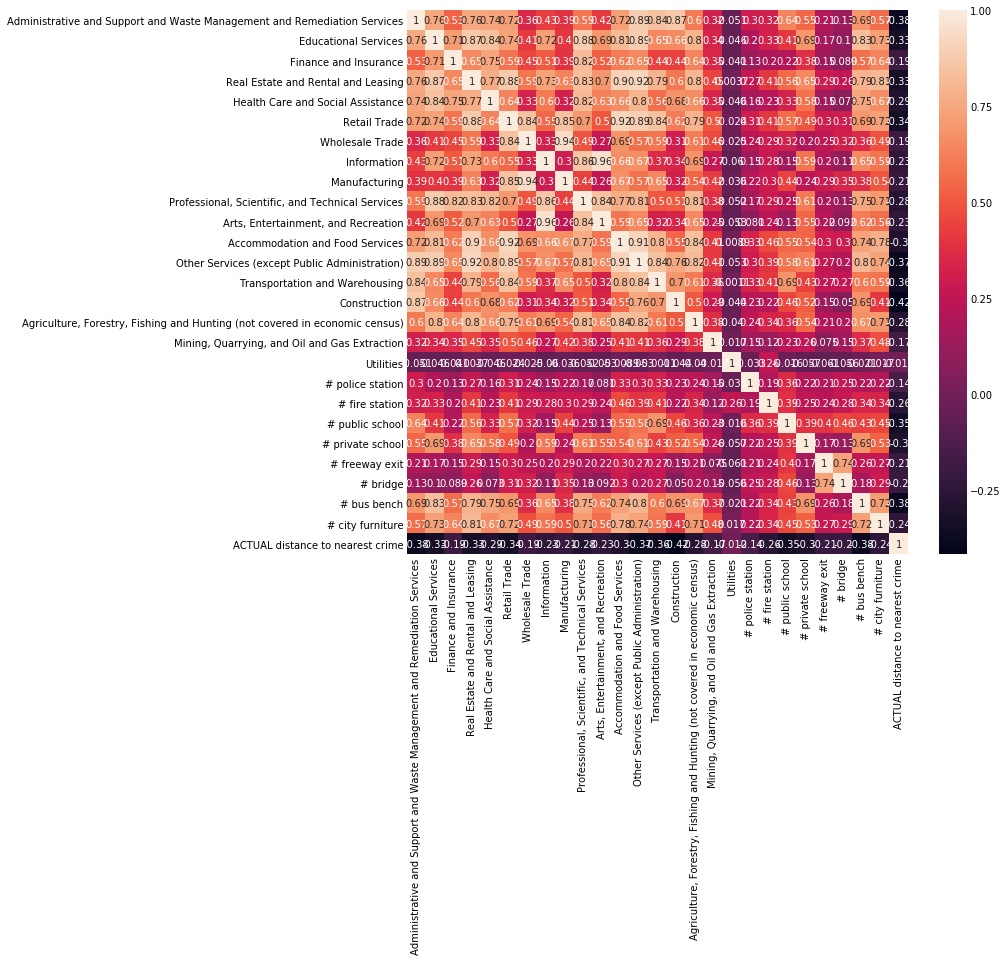

In [0]:
corrdf = la_random_1k_radius.drop(['ECEF', 'Random Point'], axis = 1)
corrmatrix = corrdf.corr()
plot.figure(figsize=(10,10))
g = sns.heatmap(corrmatrix, annot=True)
corrmatrix

# Model Selection and Reasoning
We chose to use scikit learn's Decision Tree Regressor for our modeling purposes. According to scikit the goal of this modelling technique "is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features."" This is a good model for our purposes because it is computationally inexpensive, relatively easy to understand, and does not require tons of data cleansing. 

In order to run this predictive model, as always we split our data into training, testing, and validation sets with our X being all of our features (all columns aside from  'Random Point',  'ECEF', 'ACTUAL distance to nearest crime') and Y being the ACTUAL distance to nearest crime. We then ran the model against these splits and it yielded an r-squared value of 0.8828786906689822, thus asserting this model as a good way to predit distance to nearest crime from our features. We then ran a cross validation to test our DecisionTreeRegressor once again, this yielded another promising statistic; a root mean squared error of 249.63560594716435 meters.


In [0]:
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

In [0]:
# DecisionTreeRegressor import

from sklearn.tree import DecisionTreeRegressor

In [0]:
dtrmodel = DecisionTreeRegressor()
dtrmodel.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [0]:
dtrtrainpred = dtrmodel.predict(X_train)
dtrvalpred = dtrmodel.predict(X_validate)


print('Decision Tree Regression, training R^2 score:', dtrmodel.score(X_train, y_train))
print('Decision Tree Regression, validation R^2 score:', dtrmodel.score(X_validate, y_validate))
print('Decision Tree Regression, training RMSE:', rmse(dtrtrainpred, y_train))
print('Decision Tree Regression, validate RMSE:', rmse(dtrvalpred, y_validate))

Decision Tree Regression, training R^2 score: 0.9157741994509908
Decision Tree Regression, validation R^2 score: 0.6668034588507368
Decision Tree Regression, training RMSE: 97.79834334944329
Decision Tree Regression, validate RMSE: 254.58851344322994


In [0]:
#cross validated model 

dtr_test_predicted = cross_val_predict(dtrmodel, X_test,y_test, cv=10)
print(r2_score(y_test, dtr_test_predicted))


print('Decision Tree Regression, cross validate RMSE for test set:', rmse(dtr_test_predicted, y_test))

-0.13289624680064827
Decision Tree Regression, cross validate RMSE for test set: 306.9295145305454


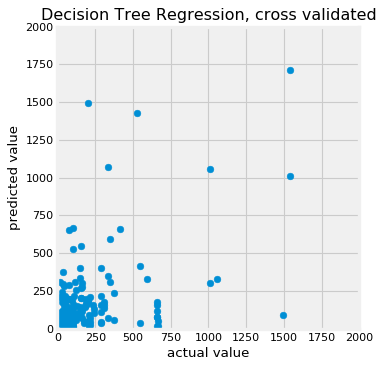

In [0]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
plot.xlim(0, 2000)
plot.ylim(0, 2000)
plot.gca().set_aspect('equal', adjustable='box')
plot.draw()
plot.scatter(dtr_test_predicted,y_test )
plot.title('Decision Tree Regression, cross validated')
plot.xlabel('actual value')
plot.ylabel('predicted value')
plot.show()




How can we improve our model? Since we are in the interesting position of being able to create our own test,train,validation datasets, we can expand our dataset by generating more random points and completing the corresponding calculations.

By increasing the size of our data set, we can mitigate the issue of bias vairance tradeoff: 
- Bias variance tradeoff refers to the balancing of two goals during the course of modeling to make predictions.
We aim to minimize test bias, which is the difference between average predictions and real values we try to predict. We can reduce bias by increasing the size of the training set, but this will result in overfitting of the model to the training set and subsequent poor performance on test data. In essence, we consider the characteristics of the training set too much.

- We aim to minimize test variance, which is the variability of our model's prediction for a given value. We can reduce test variance by increasing the size of our test set (too few points will result in large variances in estimates), however then this reduces the size of the training set. Then, our model does not consider the training set heavily enough and oversimplifies the model, leading to poor performance on both the training and test set.

- Thus there is a tradeoff between minimizing a model's bias and variance.

- In machine learning:

- high test bias + low test variance = underfitting. The model is unable to capture the underlying patterns in the data
- Low test bias + High test variance = overfitting. Our model captures too much of the data, both the underlying patterns as well as useless noise in the set.
- If the model is too simple and has few features, then it may be biased and underfitting.
- f the model is too complex and has too many features, then it may exhibit high variance and overfitting.

So it's crucial to find a sweet spot in model complexity. Fortunately for us, we don't have to make additional compromises regarding the relative size of the training, test, validation split: we can simply increase the data set overall and maintain the split.


Let's increase the number of random points to 10,000, to see what impacts we might have on the model.


In [0]:
lar10k = random_point_in(la_geom_fixed, 10000)
# create the geodataframe
la_random_10k_radius = geopandas.GeoDataFrame(data = lar10k, columns = ["Random Point"], geometry = 'Random Point')

la_random_10k_radius['ECEF'] = '2'
for index, row in la_random_10k_radius.iterrows():
  p = row['Random Point']
  x,y,z = pm.geodetic2ecef(p.x,p.y,0)
  la_random_10k_radius.at[index,'ECEF'] = list([x,y,z])

In [0]:
for i in clean_biz_data_gdf['description'].unique():
  select_i = clean_biz_data_gdf.loc[clean_biz_data_gdf['description'] == i]
  distances = ckdradius_ecef(la_random_10k_radius, select_i)
  la_random_10k_radius[i] = distances

In [0]:
la_random_10k_radius['# police station'] = ckdradius_ecef(la_random_10k_radius, police_stations_gdf)
la_random_10k_radius['# fire station'] = ckdradius_ecef(la_random_10k_radius, fire_stations_gdf)
la_random_10k_radius['# public school'] = ckdradius_ecef(la_random_10k_radius, public_geo)
la_random_10k_radius['# private school'] = ckdradius_ecef(la_random_10k_radius, priv_geo)

la_random_10k_radius['# freeway exit'] = ckdradius_ecef(la_random_10k_radius, freeway_exits_gdf)
la_random_10k_radius['# bridge'] = ckdradius_ecef(la_random_10k_radius, bridges_gdf)
la_random_10k_radius['# bus bench'] = ckdradius_ecef(la_random_10k_radius, bus_benches_gdf)
la_random_10k_radius['# city furniture'] = ckdradius_ecef(la_random_10k_radius, city_furniture_gdf)


In [0]:
# still want actual distance here
la_random_10k_radius['ACTUAL distance to nearest crime'] = ckdnearest_ecef(la_random_10k_radius, crime_data_2018_gdf)

In [0]:
# partition the 10000 data into test, train, validation sets

#specify the features used to PREDICT the distnace to the nearest crime
X10 = la_random_10k_radius.drop(['Random Point', 'ECEF','ACTUAL distance to nearest crime'], axis = 1)

# since we constructed and checked our data set, we know that there are no nan values, so no features or rows need to be dropped for this reason

# the actual distance to the nearest crime (target)
y10 = la_random_10k_radius['ACTUAL distance to nearest crime']

# set the random seed
np.random.seed(10)

# split the data with 0.20 proportion for test size, using train_test_split 
# creating training and test sets
X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y10,
                                                    train_size=0.80, test_size=0.20)

# now from the training sets, .75 of this sets will be used for training, and the other .25 for validation
X10_train, X10_validate, y10_train, y10_validate = train_test_split(X10_train, y10_train,
                                                    train_size=0.75, test_size=0.25)

In [0]:
dtr10model = DecisionTreeRegressor()
dtr10model.fit(X10_train, y10_train)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [0]:
dtr10trainpred = dtr10model.predict(X10_train)
dtr10valpred = dtr10model.predict(X10_validate)
dtr10testpred = dtr10model.predict(X10_test)

print('Decision Tree Regression, 10k training R^2 score:', dtr10model.score(X10_train, y10_train))
print('Decision Tree Regression, 10k validation R^2 score:', dtr10model.score(X10_validate, y10_validate))
print('Decision Tree Regression, 10k test R^2 score:', dtr10model.score(X10_test, y10_test))
print('Decision Tree Regression, 10k training RMSE:', rmse(dtr10trainpred, y10_train))
print('Decision Tree Regression, 10k validate RMSE:', rmse(dtr10valpred, y10_validate))
print('Decision Tree Regression, 10k test RMSE:', rmse(dtr10testpred, y10_test))

Decision Tree Regression, 10k training R^2 score: 0.9276849285317549
Decision Tree Regression, 10k validation R^2 score: 0.6333531391160425
Decision Tree Regression, 10k test R^2 score: 0.6062065553126679
Decision Tree Regression, 10k training RMSE: 88.50439186492291
Decision Tree Regression, 10k validate RMSE: 200.18601235757438
Decision Tree Regression, 10k test RMSE: 182.67746789945136


Decision Tree Regression, 10k test R^2 score: 0.6062065553126679


In [0]:
#cross validated model 

dtr10_test_predicted = cross_val_predict(dtr10model, X10_test,y10_test, cv=10)
print('Decision Tree Regression, 10k cross validate R^2 for test set:',r2_score(y10_test, dtr10_test_predicted))


print('Decision Tree Regression, 10k cross validate RMSE for test set:', rmse(dtr10_test_predicted, y10_test))

Decision Tree Regression, 10k cross validate R^2 for test set: 0.4615112397948047
Decision Tree Regression, 10k cross validate RMSE for test set: 213.61859947031294


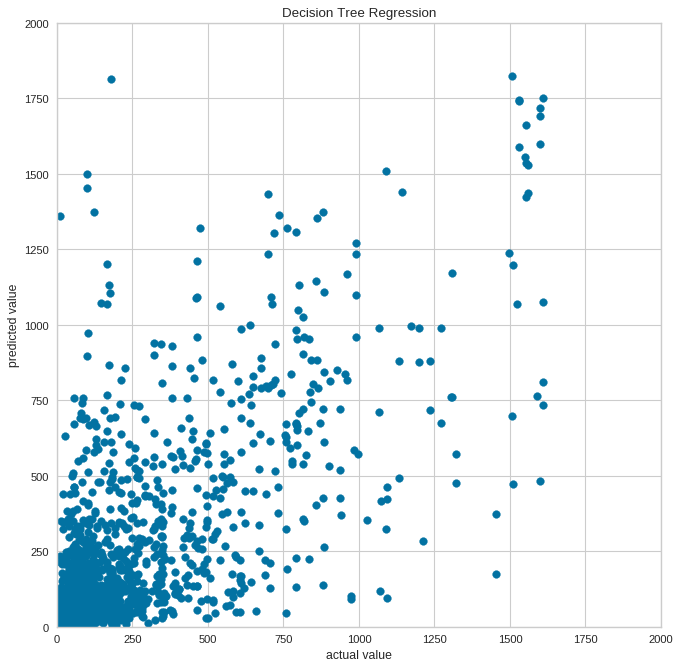

In [0]:
from matplotlib.pyplot import figure


figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plot.scatter(dtr10_test_predicted,y10_test )
plot.xlim(0, 2000)
plot.ylim(0, 2000)
plot.gca().set_aspect('equal', adjustable='box')
plot.draw()
plot.title('Decision Tree Regression, cross validated')
plot.xlabel('actual value')
plot.ylabel('predicted value')
plot.show()


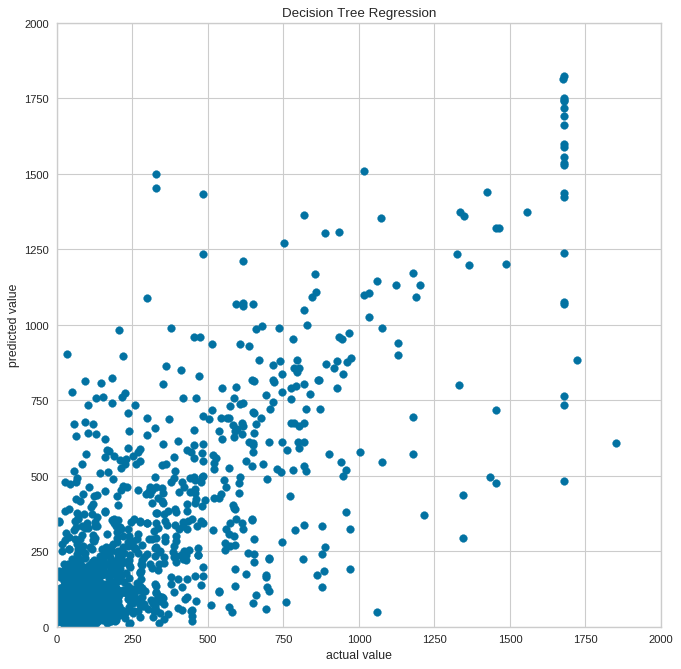

In [0]:
from matplotlib.pyplot import figure


figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plot.scatter(dtr10testpred,y10_test )
plot.xlim(0, 2000)
plot.ylim(0, 2000)
plot.gca().set_aspect('equal', adjustable='box')
plot.draw()
plot.title('Decision Tree Regression')
plot.xlabel('actual value')
plot.ylabel('predicted value')
plot.show()


So what effect did the increase from 1000 to 10,000 points have?

We see that the training and validation, as well as cross validated test score all improved noticably. 

Decision Tree Regression, 10k training R^2 score: 0.9305282597872718
Decision Tree Regression, 10k validation R^2 score: 0.6425765339241873
Decision Tree Regression, 10k training RMSE: 84.23093976861838
Decision Tree Regression, 10k validate RMSE: 206.87885978069872
Decision Tree Regression, 10k cross validate RMSE for test set: 225.1032134600327



The plot is similar but with many more points than before, since the test set also grew. We can see that our data isn't completely random scatter, and that there is indeed somewhat of a linear pattern forming. Again, the bulk of actual and predicted distances seem to fall below 500 meters, where the model now more clearly seems to predict lower than actual scores more oftan than high than actual scores. 

Can we say that this model run on 10k points instead of 1k points is better? R^2 and RMSE aren't great at identifying which is the best model in this case. So we use the AIC or BIC approaches:

<b> AIC Akaike Information Criterion </b>
- AIC and BIC both offer an estimate of the relative information lost when a given model is used to represent the process that generated the data
- This is a computationally efficient method of gauging model quality
- This only offers assessment of model quality relative to other candidate models, but this is ok for our purposes.

<b> BIC Bayes Information Criterion  </b>
- BIC penalizes complexity more heavily
- BIC works better when the known "true / real" model is in the set of models compared (not true in our case)


So since we don't know the true or real model to be here, we use AIC

$AIC = 2k - 2ln(sse)$

$BIC = n*ln(sse/n) + k*ln(n)$


In [0]:
#aic for 1k
# Columns
k = len(X_train.columns)
# Rows
n = len(X_train.index)


resid1k = y_train - dtrtrainpred
model1k_sse = sum(resid1k**2)

m1k_AIC = (2*k) - (2*(np.log(model1k_sse)))
print('1k AIC', m1k_AIC)




1k AIC 20.874510138647484


In [0]:
# aic for the 10k model:

# Columns
k10 = len(X10_train.columns)
# Rows
n10 = len(X10_train.index)


resid10k = y10_train - dtr10trainpred
model10k_sse = sum(resid10k**2)

m10k_AIC = (2*k10) - (2*(np.log(model10k_sse)))
print('10k AIC', m10k_AIC)



10k AIC 16.66876179807992


And we see, that the 10k model returns a lower score, and thus of better quality according to AIC.


So then what happens if we run the cross validated 10k model on the 1k test set?

In [0]:
#cross validated model 

final_test_predicted = cross_val_predict(dtr10model, X_test,y_test, cv=10)
print(r2_score(y_test, final_test_predicted))


print('Decision Tree Regression, 10k cross validate RMSE for test set:', rmse(final_test_predicted, y_test))

-0.04305095534886316
Decision Tree Regression, 10k cross validate RMSE for test set: 294.5074911432073


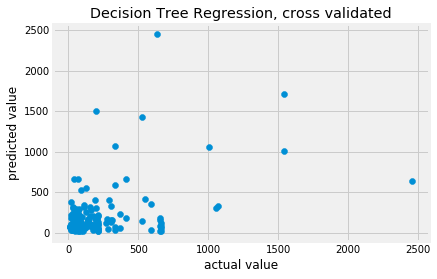

In [0]:
plot.scatter(final_test_predicted,y_test )

plot.title('Decision Tree Regression, cross validated')
plot.xlabel('actual value')
plot.ylabel('predicted value')
plot.show()




One interesting thing to note is that the collective performance of the model varies greatly when there are only a few points to predict. 

So how often does our model over / under predict? What does it tend to do? It seems to over predict at lower distances, and under predict at higher distances (with larger residuals too, not unexpected as the bulk of data is at lower distances). This can indicate that the actual distances that are larger are, less common than others, and also perhaps contributing less to the training data. This is quite obvious when we look at the histogram of distances below. The vast majority are within 250 meters.


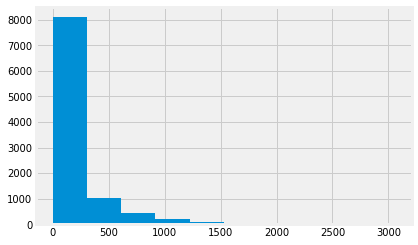

In [0]:
la_random_10k_radius['ACTUAL distance to nearest crime'].hist()

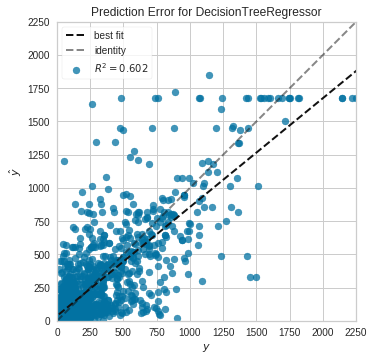

In [0]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
# Instantiate the visualizer
visualizer = PredictionError(dtr10model)

visualizer.fit(X10_train, y10_train)  
visualizer.score(X10_test, y10_test)  
visualizer.poof()        

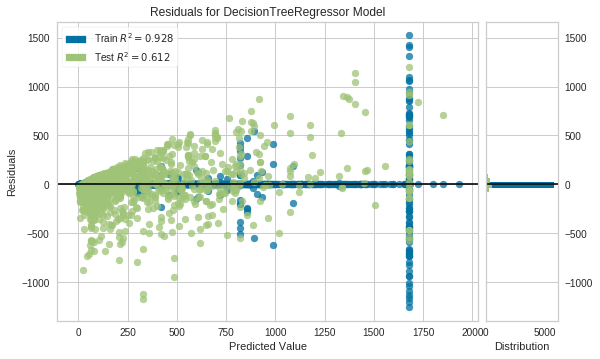

In [0]:
resvisualizer = ResidualsPlot(dtr10model)
resvisualizer.fit(X10_train, y10_train)  
resvisualizer.score(X10_test, y10_test)  
resvisualizer.poof()        

More importantly, how accurate was the model?  Proportions are more important than absolute distance, since our model is dealing with points at varying distances

In [0]:
div = dtr10trainpred/y10_train
div.describe()

count    6000.000000
mean        1.008052
std         0.189535
min         0.572183
25%         1.000000
50%         1.000000
75%         1.000000
max        10.709634
Name: ACTUAL distance to nearest crime, dtype: float64

In [0]:
d2 = dtr10valpred/y10_validate
d2.describe()

count    2000.000000
mean        1.618279
std         3.413441
min         0.021895
25%         0.597466
50%         1.026303
75%         1.701876
max        82.728715
Name: ACTUAL distance to nearest crime, dtype: float64

In [0]:
d3 = dtr10_test_predicted/y10_test
d3.describe()




count    2000.000000
mean        1.667248
std         2.867909
min         0.005354
25%         0.557707
50%         1.004731
75%         1.768799
max        67.724980
Name: ACTUAL distance to nearest crime, dtype: float64

In [0]:
# show the feature importance
pd.DataFrame({'feature': X10.columns,
             'importance': dtr10model.feature_importances_}).sort_values('importance', ascending= False)

feature    importance
12      Other Services (except Public Administration)  4.535965e-01
9    Professional, Scientific, and Technical Services  1.266686e-01
0   Administrative and Support and Waste Managemen...  7.417816e-02
3                  Real Estate and Rental and Leasing  5.261819e-02
23                                           # bridge  4.543444e-02
11                    Accommodation and Food Services  4.068976e-02
4                   Health Care and Social Assistance  2.313290e-02
14                                       Construction  2.030750e-02
10                Arts, Entertainment, and Recreation  1.848757e-02
7                                         Information  1.712755e-02
8                                       Manufacturing  1.709017e-02
6                                     Wholesale Trade  1.689098e-02
2                               Finance and Insurance  1.406104e-02
13                     Transportation and Warehousing  1.394836e-02
1                                Educational Services  1.355691e-02
5                                        Retail Trade  1.295856e-02
25                                   # city furniture  8.542247e-03
21                                   # private school  7.940206e-03
20                                    # public school  6.730482e-03
15  Agriculture, Forestry, Fishing and Hunting (no...  5.032627e-03
19                                     # fire station  4.558897e-03
24                                        # bus bench  4.555871e-03
22                                     # freeway exit  1.076636e-03
16      Mining, Quarrying, and Oil and Gas Extraction  8.080308e-04
18                                   # police station  7.739683e-06
17                                          Utilities  1.456628e-07

So, the model doesn't perform that great, as it over and underestimates eften and to a degree that is quite problematic (near 50% low or high, about 50% of the time)

Interestingly, it performs fantastic on the training set. This is quite characteristic of an overfitting problem. Let's try to mitigate this by using an averaging ensemble methods.

<b>Ensemble methods try to improve on  single-model approaches by combining the predictions from multiple base models.




<b> Random Forest
Random Forest will create multiple decision trees, each trained on sample of data drawn at random WITH replacement from the given set. 
When each tree is constructed, not every feature is considered as a candidate on which to split the tree for each decision point.

"By adding some randomization into the subsets and features that are considered by each model, then averaging the predictions across models, Random Forest can typically produce a model that is better at generalization.""

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
rf_reg = RandomForestRegressor()
# fit the data 
rfrmodel = rf_reg.fit(X10_train, y10_train)

#score the model on the training and validation data
print(rfrmodel.score(X10_train, y10_train))
print(rfrmodel.score(X10_validate, y10_validate))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8960988110232597
0.739382966631311


So we see a drop in training r^2 but an incredible increase in validation r^2 for models trained on the 1000 dataset, and also 10000 dataset. These results are very encouraging.

Can we improve even more? Let's search for the best parameters, using GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
# create a parameter grid to look for optimal values for n_estimators, max_depth, and _min_samples_split
param_grid = {'n_estimators': range(10, 100, 10),
              'max_depth': range(1, 80, 10),
              'min_samples_split': [2]}



In [0]:
# don't run unless needed: takes a while
grid_search = GridSearchCV(RandomForestRegressor(), param_grid)
grid_search.fit(X10_train, y10_train)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(10, 100, 10), 'max_depth': range(1, 80, 10), 'min_samples_split': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
# the keys stored in the grid search process results dictionary
sorted(grid_search.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_max_depth',
 'param_min_samples_split',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [0]:
grid_search.cv_results_["params"]

[{'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 10},
 {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 20},
 {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 30},
 {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 40},
 {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 50},
 {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 60},
 {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 70},
 {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 80},
 {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 90},
 {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 10},
 {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 20},
 {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 30},
 {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 40},
 {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 50},
 {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 60},
 {'max_depth': 11, 'min_samples_split': 2, 'n_est

In [0]:
grid_search.cv_results_["mean_test_score"]

array([0.4448272 , 0.43670509, 0.43569661, 0.43742826, 0.43177602,
       0.43416319, 0.43234562, 0.43456196, 0.43624285, 0.70610536,
       0.71551867, 0.71487394, 0.71893499, 0.71979838, 0.71882958,
       0.71799441, 0.72005925, 0.71935645, 0.70989309, 0.72394722,
       0.72997388, 0.73095673, 0.72896028, 0.73222952, 0.73281164,
       0.73501542, 0.73307599, 0.71429325, 0.71723616, 0.72831038,
       0.72991428, 0.72989279, 0.73276038, 0.73247589, 0.72985338,
       0.73151937, 0.71400264, 0.71950523, 0.73208369, 0.73235548,
       0.7319549 , 0.72901913, 0.73345731, 0.72887181, 0.73234467,
       0.70700214, 0.72380849, 0.7289006 , 0.73124803, 0.73025899,
       0.73189998, 0.73149925, 0.73542146, 0.73189383, 0.72193652,
       0.72475254, 0.72614117, 0.72782465, 0.72902175, 0.73185743,
       0.73215345, 0.73406381, 0.73442984, 0.72132919, 0.72216808,
       0.72865053, 0.72851708, 0.73155229, 0.73314036, 0.73074724,
       0.73353976, 0.73268861])

In [0]:
best_index = np.argmax(grid_search.cv_results_["mean_test_score"])
best_params = grid_search.cv_results_["params"][best_index]

In [0]:
best_index

52

In [0]:
best_params

{'max_depth': 51, 'min_samples_split': 2, 'n_estimators': 80}

GridSearchCV is suggesting best parameters of: max depth seemes to be allowed unlimited, min sample split remain at 2, and n_estimators at about 50 or 60.

In [0]:
rf_regop = RandomForestRegressor(n_estimators = 50)
# fit the data 
rfrmodel2 = rf_regop.fit(X10_train, y10_train)
finaltrain = rfrmodel2.predict(X10_train)
finalval = rfrmodel2.predict(X10_validate)
#score the model on the training and validation data
print(rfrmodel2.score(X10_train, y10_train))
print(rfrmodel2.score(X10_validate, y10_validate))

print('Random Foreset Regression Paramater Optimized, 10k  RMSE for train set:', rmse(finaltrain, y10_train))
print('Random Foreset Regression Paramater Optimized, 10k  RMSE for validation set:', rmse(finalval, y10_validate))

0.9050699430120037
0.7588781423022578
Random Foreset Regression Paramater Optimized, 10k  RMSE for train set: 101.40334543532848
Random Foreset Regression Paramater Optimized, 10k  RMSE for validation set: 162.3409315047245


Ok, this seems to give a small but noticable improvement: we'll stick with this as our final model.

Now lets run it on the test set.

In [0]:
print('RFR Parameter Optimized, r2 score for 10k test:',rfrmodel2.score(X10_test, y10_test))
#print('RFR Parameter Optimized, r2 score for 1k test:',rfrmodel2.score(X_test, y_test))
finaltest10 = rfrmodel2.predict(X10_test)
finaltest1 = rfrmodel2.predict(X_test)
print('Random Forest Regression Parameter Optimized, 10k  RMSE for test set:', rmse(finaltest10, y10_test))
#print('Random Forest Regression Parameter Optimized, 1k  RMSE for test set:', rmse(finaltest1, y_test))

RFR Parameter Optimized, r2 score for 10k test: 0.7790517683325369
Random Forest Regression Parameter Optimized, 10k  RMSE for test set: 136.83462523422614


Quite good performance on both the smaller 1000 instance and larger 10000 instance sets. 
Now some final visualizations and statistics:

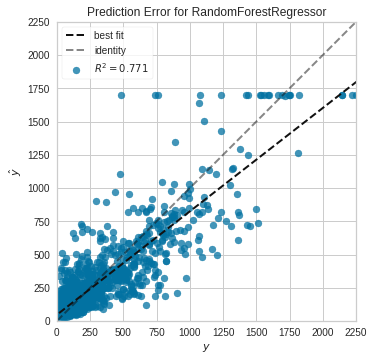

In [0]:
visualizer_rfr = PredictionError(rfrmodel2)

visualizer_rfr.fit(X10_train, y10_train)  
visualizer_rfr.score(X10_test, y10_test)  
visualizer_rfr.poof()        

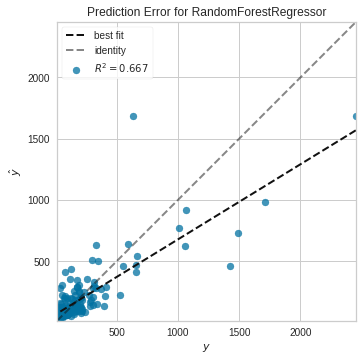

In [0]:
visualizer_rfr2 = PredictionError(rfrmodel2)

visualizer_rfr2.fit(X10_train, y10_train)  
visualizer_rfr2.score(X_test, y_test)  
visualizer_rfr2.poof()        

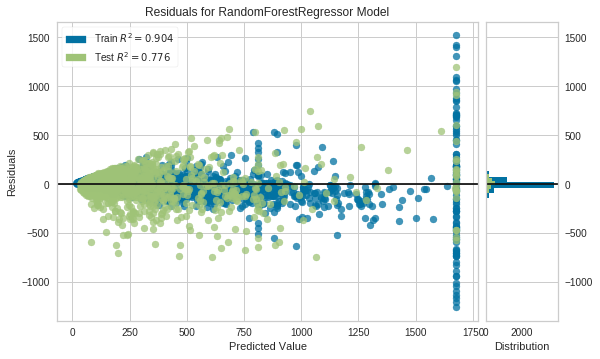

In [0]:
resvisualizer_rfr = ResidualsPlot(rfrmodel2)
resvisualizer_rfr.fit(X10_train, y10_train)  
resvisualizer_rfr.score(X10_test, y10_test)  
resvisualizer_rfr.poof()        

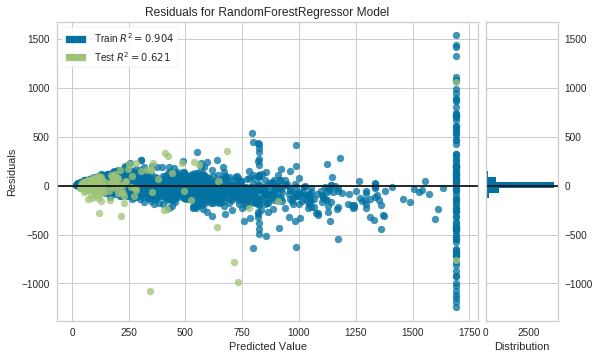

In [0]:
resvisualizer_rfr1 = ResidualsPlot(rfrmodel2)
resvisualizer_rfr1.fit(X10_train, y10_train)  
resvisualizer_rfr1.score(X_test, y_test)  
resvisualizer_rfr1.poof()        

In [0]:
d4 = finaltest10/y10_test
d4.describe()




count    2000.000000
mean        1.641857
std         2.068743
min         0.126061
25%         0.793768
50%         1.099263
75%         1.750157
max        35.334945
Name: ACTUAL distance to nearest crime, dtype: float64

In [0]:
d5 = finaltest1/y_test
d5.describe()




count    200.000000
mean       1.494634
std        1.174354
min        0.223186
25%        0.795182
50%        1.149046
75%        1.736339
max        8.321566
Name: ACTUAL distance to nearest crime, dtype: float64

In [0]:
# show the feature importance
pd.DataFrame({'feature': X10.columns,
             'importance': rfrmodel2.feature_importances_}).sort_values('importance', ascending= False)

feature  importance
12      Other Services (except Public Administration)    0.306658
5                                        Retail Trade    0.147799
9    Professional, Scientific, and Technical Services    0.136852
3                  Real Estate and Rental and Leasing    0.058313
8                                       Manufacturing    0.050318
23                                           # bridge    0.035314
6                                     Wholesale Trade    0.033295
0   Administrative and Support and Waste Managemen...    0.031741
14                                       Construction    0.028230
10                Arts, Entertainment, and Recreation    0.024310
11                    Accommodation and Food Services    0.022534
7                                         Information    0.017539
13                     Transportation and Warehousing    0.017510
2                               Finance and Insurance    0.015922
4                   Health Care and Social Assistance    0.013883
1                                Educational Services    0.011521
20                                    # public school    0.011188
25                                   # city furniture    0.009349
24                                        # bus bench    0.007724
21                                   # private school    0.006872
15  Agriculture, Forestry, Fishing and Hunting (no...    0.005040
19                                     # fire station    0.003573
22                                     # freeway exit    0.002517
16      Mining, Quarrying, and Oil and Gas Extraction    0.001787
18                                   # police station    0.000143
17                                          Utilities    0.000068

So while our final model is by no means perfect, it's quite a nice and significant improvement over what we began with.

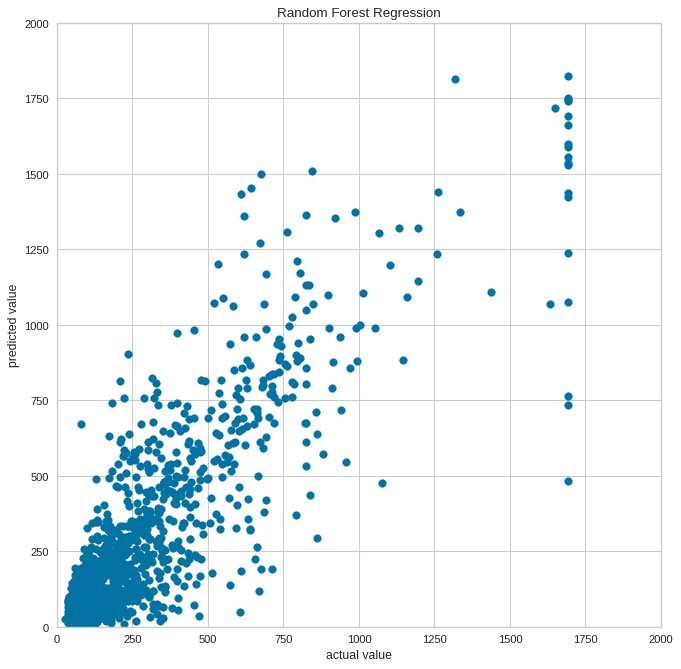

In [0]:


figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plot.scatter(finaltest10,y10_test )
plot.xlim(0, 2000)
plot.ylim(0, 2000)
plot.gca().set_aspect('equal', adjustable='box')
plot.draw()
plot.title('Random Forest Regression')
plot.xlabel('actual value')
plot.ylabel('predicted value')
plot.show()


In [0]:
len(clean_biz_data_gdf.loc[clean_biz_data_gdf['description'] == 'Other Services (except Public Administration)'])/len(clean_biz_data_gdf)

0.1175678815305669

# Conclusion / Summary & Write Up

<b> The Big Questions </b>

- Is there a relationship between crime and certain types of establishments in society?
- Is the presence of crime related to the location of businesses, schools, parks, government buildings, prisons, infrastructure, etc.? 
- Do all establishments in society have the same or similar impact on the occurrence of crime? 

Why are these questions important? We think the interaction between the built environment and the people within it is fascinating: we want to better understand how people and their surrounding inform one another, how they influence the development of each other. We often hold many prejudices and assumptions about locations and physical spaces in society: are these stereotypes and conclusions true? Do they hold up to analysis, or are they products of our imagination

- Could we answer these questions with data analysis?

<b> The Data:</b>
- We have a wide variety of data at our disposal: we want to select spatial features that are interesting, meaningful, and applicable to everyday life. Things that we can see in our normal, everyday surroundings.

Sources included:

City of Los Angeles Data Hub
- Listing of Active Businesses (& NAICS codes from the US Census Bureau)
- Crime Data from 2010 to Present

City of Los Angeles GeoHub
- Police & Fire Stations
- Bus Benches
- Bridges
- Freeway Exits
- City Furniture
- LA City Boundaries

California Department of Education
- Public & Private K-12 Schools


These form four overall feature categories: Businesses, education, infratructure, and public safety
- We feel that these are a good sampling of the diverse variety of places that we might encounter daily, and are relavent to our analysis

<b> The Goal </b>

How do we investigate if there is indeed a relationship between crime and certain types of establishments in society? Our methodolgy here evolved as our understanding of the scope, ethics, and technical characteristics of the problem changed:

Predicting the location of the nearest crime to instances of features
- Constrained by technical challenges: too much data

Predicting the coordinate location of nearest crime based on relative location of features to a random point
- Constrained by technical challenges, ethical issues. For one, it's difficult to do this, but also of questionable ethical standing and of questionable utility as well. We predict the location of the closest crime: so what does this tell us about our features? Not much

- Predicting distance to nearest crime, given number of each feature within radius r of random point
- Feasible, allows us to make progress to answer questions responsibly. If we are certain to understand the predicted distances as a sort of score, perhaps this can be a proxy for understanding the real effects of the features.



<b> Data Cleaning and Processing: </b>

This was perhaps the most tedious and time consuming part of the project.

Key takeaways: working with coordinates is finicky
- The basic unit here: the coordinate pair / point
- Any instance of data that has an address but not coordinate must be geocoded: geocoding large numbers of points is deceptively straightforward, but there aren't that many places that offer free and fast geocoding. Thanks to Texas A&M Geoservices for their free geocoding service
- Remove any point, from any data set, that  is not in the geometry of the City of LA: important, we don't want any unintentional outliers here, and we want to remove any outliers that might be the result of inaccurate geocoding, or otherwise faulty data
- Convert coordinate points from a geodesic to a cartesian ECEF XYZ system, this way we can actually process them with ckdtrees. Otherwise what it returns is uninterprable.
- Need to leverage fast, efficient menthods like scipy ckdtrees to achieve desired results quickly
- Awareness of what units and <b> HOW </b> the methods, functions, tools etc we use actually work is **critical**: treating these as magic black boxes will easily result in confusion, misappropiration, and uninterperable, useless results and data. This was a major issue for distance calculations: turns out, documentation on the units that ckdtrees, etc took is scarce, and it is NOT safe to assume unknown units, etc. A lot of meticulous research was performed here.


<b> The basic modeling approach</b>
Building the Dataset
- First, we generated random points within City of LA: these will serve as our data instances
- Next, we create custom functions using scikit ckdTrees: to find the n-nearest neighbors within r radius, from each feature, to points. The numbers found here will be used to build our dataset X.
- The true output value: Actual distance to the nearest crime, meters, is listed as the y value for all instances of random points

<b> Feaure Selection and our model </b>
 
 We didn’t think it was appropriate to perform feature selection for a variety of reasons
- We cannot pick and choose what is / is not present in the already built real world
- We selected these features: If anything, we should consider as many as possible in this situation: we don't think that ignoring features without empirical evidence is responsible or realistic.  We have a relatively low number of features here as well.
- We’re interested in interactions between features as well. How do they influence one another? 
- We want our model to inform our considerations, not the other way around. It's ok if it turns out that some features are indeed more "important" than others: but we want this come as a result of our model. 
- Preliminary inspection of our feature correlation matrix doesn't seem to reveal much interesting that could contribute to feature selection: there doesn't seem to be any feature particularly correlated with the distance of the nearest crime.


<b> The Models </b>

Decision Tree Regression  was the first model we selected. It has various features and benefits, includingImplicit feature selection, the need for relatively little data cleaning, the non-affecting nature of Nonlinear relationships between features on performance, and the fact that it is quite computationally inexpensive.

However, DTR provided results that in the test and validation trials were slightly better than chance usually, with the best R^2 around .60. 
Cross Validation fails to improve these results, in fact worsening performance. Interestingly: we see that the R^2 of the training set was nearly maxed out, so this seemed to be characteristic of an overfitting issue.

To mittigate this, we then attempted a Random Forest Regression approach. Here, in essence,  we create multiple decision trees, each trained on data drawn randomly with replacement from given set. Randomization is  introduced into subsets and features considered by models
The model then averagse predictions across models. This usually results in a model that generalizes better. We obeserved: a nice increase in performance from the decision trees alone, with results about 30% better compared to test of the decision tree. We did lose some performance on the training set, but this is not really an issue at all. 


We are happy to report a .77 r^2, and RMSE of about 136 meters as the final result of our model.

NOTE: Since we are in the interesting position of being able to create our own test,train,validation datasets, we we chose to expand our dataset over our intial size of 1000 instnaces overall: Why? See the above, but in summary,  By increasing the size of our data set, we can mitigate the issue of bias vairance tradeoff: here, we can optimize both test bias, as well as test variance. Fortunately for us, we don't have to make additional compromises regarding the relative size of the training, test, validation split: we can simply increase the data set overall and maintain the split. This also yielded a modest but noticable improvement in our model performance. We did take care as to generate an excessive number of random points (ie, oversaturation of the subject area with random points), and limited to a reasonable 10000.

<b> Our findings </b>

Our main findings concern feature importance: our goal from the outset was to determine if features has differing impacts on the occurence of crime. We are inclined to believe that this is true: There were some interesting surprises.

From our feature importance table generated from our final Random Forest Regression model, we see some very intersting results: Note: 

By far the most "important" feature in the model (scoring .3, 2x more than the next highest) was "Other Services" which constituted 11.76% of businesses in data. This category includes, Repair and maintenance of autos, electronics,  commercial equipment, household goods, Personal care, laundry, and death services, Religious, Social, Professional, and civic organizations, Private Households (domestic jobs). Unfortunately, we didn't subdivide this category into sub categories, so we can't make more specific conclusions, but this was quite a surprising results. For a category of businesses that we might dismiss or omit altogether, it has a major impact on the model.

The next most important feature was "Retail Trade," followed by "Profesional, Scientific, and Technical services." Interestingly, "bridges" was also among the more important features. 

Most fascintating was that public safety: police and fire stations, ranked near the bottom of the list in terms of importance. This was quite a shock, and we think most people would be surprised with the insignificance of these features on the model. 

If we were to do this again, we would certaintly include more narrow categorizations of features, and more features overall. 

The next steps we would take with our findings is to understand why these features ranked the way they did. We can speculate, perhaps it's due to the number of each feature,  immediate surrounding, or may be some other factors. But this provides a very interesting foundation for research on the interaction and impact of establishments on crime in society. 

<b> Our Conclusions</b>

YES: it does appear that certain features are more important to the prediction of crime. 

Why? We can't say for sure.

It's extremely important to note, our purpose in conducting this project was NOT to predict crime. It was NOT focused on policing: we are interested in spatial features and their interactions with one another and crime: we are NOT trying establish a relationship between "coffee shops" and "drive by shootings." Our model should not be used without understanding of its purpose and contexts. 

Ethics became a major concern for us: we understand how such a model like ours could be interpreted or used as a crime prediction / policing tool: this was never our intent, and we warn against anyone doing so. 
- For one, while we are quite pleased with near .8 r^2, we don't think this is anywhere near the requisite strength needed for a model or tool that could have very real and life changing consequences for people. 
- Aside from accuracy: crime is not just infleunced by spatial features: we select only a very small number of features to model upon, there are an unimaginable number of other spatial features that could and perhaps should be investigated. We did not select these features with some empirical basis: we only did so because we wanted to test our percetions. Apart from the spatial, we could also consider temporal, demographic, economic, etc factors in modeling a predictor of crime. We also did not make connections between spatial features and their social impacts. We think without further and very thorough thought and investigation, wilful ignorance in the name of model performance is extremely dangerous approach. 

We learned a lot about ethical data science from this project: asking the right questions, forming the right goals, making the right predictions, etc. 

Again, this provides a very interesting foundation for further exploration of these feature patterns.



